In [1]:
#######################################################################
#
# lvm-dap-conf: main script to run the LVM-DAP
#
# 
# Notebook version of the lvm-dap-conf script. It runs using the same required inputs and configuration files.
# 
# It requires as inpunts: (1) a YAML file, (2) an input LVM-frame and (3) a label to define the output files
#
# (1) yaml_path = "lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl_few.yaml"
# (2) lvm_file = 'data_v1.1.1/lvmSFrame-00006109.fits'
# (3) label = 'dap-nb-00006109_few'
#
#
# The content and the format both the YAML and LVM-file should be the same as the ones
# used for the command-line script
#
#

In [2]:
###########################################################################
#
# Defining the environment settings and loading the required models
#
###########################################################################
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Core Python libraries
import numpy as np
import yaml
from astropy.table import Table
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from astropy.io import fits

# pyFIT3D and LVM DAP imports (assuming they are installed in your environment)
from lvmdap.pyFIT3D.common.io import clean_preview_results_files, print_time
from lvmdap.pyFIT3D.common.io import trim_waves
from lvmdap.dap_tools import (
    load_LVM_rss, load_LVMSIM_rss, load_in_rss,
    read_PT, read_MaStar_PT, read_LVMSIM_PT,
    read_tab_EL, find_redshift_spec,
    plot_spec_art, plot_spec, fit_legendre_polynomial,
    read_rsp, read_coeffs_RSP, read_elines_RSP, Table_mean_rows,
    replace_nan_inf_with_adjacent_avg, find_continuum, find_closest_indices,
    find_closest_indices_different, read_RSS_PT
)
from lvmdap.flux_elines_tools import flux_elines_RSS_EW_cl
from lvmdap.dap_tools import sort_table_by_id
#from lvmdap.flux_elines_tools import flux_elines_RSS_EW_cl
#from lvmdap.modelling.auto_rsp_tools import auto_rsp_elines_rnd
from lvmdap._cmdline.dap import auto_rsp_elines_rnd
from lvmdap.dap_tools import nanaverage

from lvmdap.pyFIT3D.common.constants import __c__, __Ha_central_wl__, _MODELS_ELINE_PAR
from lvmdap.pyFIT3D.common.auto_ssp_tools import load_rss, dump_rss_output
from astropy.table import join as tab_join
from astropy.table import vstack as vstack_table
from lvmdap.pyFIT3D.common.gas_tools import kin_rss_elines_main
#from lvmdap.elines.kin_elines import kin_rss_elines_main, _MODELS_ELINE_PAR
#from lvmdap.dap_tools import trim_waves

In [3]:
###########################################################
#
#  Load config YAML file
#
###########################################################

# YAML for orion
#yaml_path = "lvm-dap_ORION_test_int.yaml"  # Update this if your file has a different name/path

# YAML for v1.1.1
yaml_path = "lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl.yaml"

# YAML for tests
#yaml_path = "lvm-dap_SD_fast_SN20_ofelia_nosky_hack_cl_few.yaml"


with open(yaml_path, 'r') as stream:
    config = yaml.safe_load(stream)

# Replace relative paths and pull all parameters into the namespace
lvmdap_dir = config.get("lvmdap_dir", ".")

keys = []
for key in config:
    keys.append(key)
keys = np.array(keys)

a_name=[]
a_value=[]




for key in keys:
    a_name.append(str(key))
    a_value.append(str(config[key]))
    if isinstance(config[key], str):
        config[key] = config[key].replace("..", lvmdap_dir)
    if (key.find("-")>-1):
        clean_key = key.replace("-", "_")
        value = config[key]
        config[clean_key] = value
#        del config[key]

tab_info=Table((a_name,a_value),names=('param','value'))
#hdu_info = fits.BinTableHDU(tab_info,name='INFO')

config["flux_scale"] = config["flux_scale_org"]    
    
config_items = [(k, v) for k, v in config.items()]
config_table = Table(rows=config_items, names=["param", "value"])
config_table.show_in_notebook()      



In [5]:
###########################################################
#                                                         #
#  Define input LVM-file and the output files' label      #
#                                                         #
###########################################################

#config["ny_range"] = (0,5)

# 1st data set
#lvm_file = "sel_1.1.0/sel-00020063.fits" #config["lvm_file"]

# 2nd data set
#lvm_file = "orion/sec-orion.fits"
lvm_file = "orion/sec-orion_all.fits"
label = "orion_all_nb" #config["label"]
#config["in_rss"] = True

# 3rd data set
#lvm_file = 'data_v1.1.1/lvmSFrame-00006109.fits'
#label = 'dap-nb-00006109'
#label = 'dap-nb-00006109_few'
config['label'] = label

# If you want to fit just a few spectra for testing
config["ny_range"] = (0,10)

#

# We restrict the fitting to a very narrow range of spectra
#config["ny_range"] = ()
#0
#  - 10

In [6]:
######################################################################
#
#  Load the LVM-file 
#
######################################################################


# Choose input file
config["lvm_file"] = lvm_file 
config["label"] = label  


plot = int(config.get("plot", 0))
ny_range = config.get("ny_range", None)
nx_range = config.get("nx_range", None)

# Load spectrum
if config.get("lvmsim", False):
    wl, rss_flux, rss_eflux, hdr_flux, hdr_0 = load_LVMSIM_rss(lvm_file, ny_range=ny_range, nx_range=nx_range)
    pt_table = read_LVMSIM_PT(lvm_file, 'none', ny_range=ny_range)
elif config.get("in_rss", False):
    wl, rss_flux, rss_eflux, hdr_flux, hdr_0 = load_in_rss(lvm_file, ny_range=ny_range, nx_range=nx_range)
    try:
        pt_table = read_MaStar_PT(lvm_file, 'none', ny_range=ny_range)
    except:
        # Create placeholder PT table
        try:
            pt_table = read_RSS_PT(lvm_file, ny_range = ny_range)
        except:
            NL = rss_flux.shape[0]
            pt_table = Table()
            pt_table['id'] = np.arange(NL)
            pt_table['mask'] = np.full(NL, True)
else:
    wl, rss_flux, rss_eflux, hdr_flux, hdr_0 = load_LVM_rss(lvm_file, ny_range=ny_range, nx_range=nx_range, m2a=1)
    pt_table = read_PT(lvm_file, 'none', ny_range=ny_range)

#
# This should be included in the load_LVM_rss ??
#
try:
    hdu_LSF = fits.open(lvm_file)
    LSF_mean = np.nanmedian(hdu_LSF['LSF'].data,axis=0)/2.354
except:
    LSF_mean =  config['sigma_gas'] * np.ones(rss_flux.shape[1])
    
    

# Replace bad values
rss_flux = replace_nan_inf_with_adjacent_avg(rss_flux)
rss_eflux = replace_nan_inf_with_adjacent_avg(rss_eflux)
rss_eflux[rss_eflux == 0] = np.nanmedian(rss_eflux)

print(f"Loaded {rss_flux.shape[0]} spaxels.")


/home/sanchez/.local/lib/python3.8/site-packages/lvmdap/dap_tools.py:639: RuntimeWarning: divide by zero encountered in true_divide
  hdu_e = fits.ImageHDU(data=1/np.sqrt(rss_ivar),header=hdu[1].header,name='ERROR')


# sky re-evaluated
# sky-hack did not work
# Y-axis trimmed: (0, 10)
Loaded 10 spaxels.


In [7]:
##############################################################
#
# Apply mask to original data first
#
##############################################################

rss_flux_masked = rss_flux[pt_table['mask']]
rss_eflux_masked = rss_eflux[pt_table['mask']]
auto_z_min = config.get("auto_z_min", -0.003)
auto_z_max = config.get("auto_z_max", 0.005)

w0 = 6530 * (1 + auto_z_min)
w1 = 6650 * (1 + auto_z_max)
mask_line = (wl > w0) & (wl < w1)
# Recalculate SN_map using the masked data
SN_map_masked = np.array([
    np.nanmax(f[mask_line] / e[mask_line])
    for f, e in zip(rss_flux_masked, rss_eflux_masked)
])

# Apply S/N threshold
SN_threshold = 3
high_SN_mask = SN_map_masked > SN_threshold

# Compute the integrated flux based on S/N
if np.sum(high_SN_mask) < 3:
    int_flux = nanaverage(rss_flux_masked, 1 / rss_eflux_masked**2, axis=0)
else:
    int_flux = nanaverage(rss_flux_masked[high_SN_mask], 1 / rss_eflux_masked[high_SN_mask]**2, axis=0)

# Estimate the error in the integrated spectrum
int_eflux = np.sqrt(np.nanmedian(rss_eflux_masked**2, axis=0))


🔍 Estimating redshift from integrated spectrum...


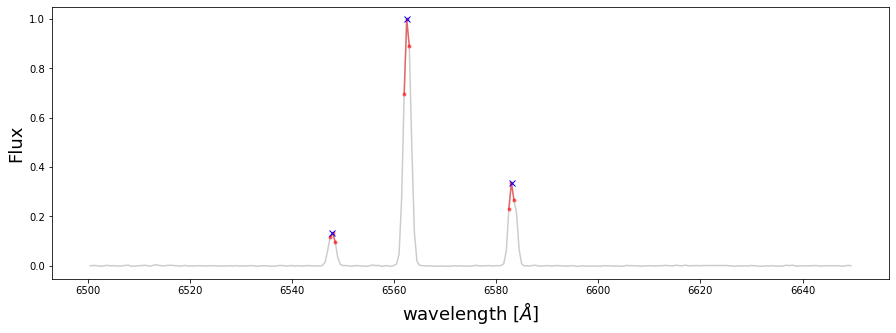

# f_peaks auto_redshift : [0.1322 0.9983 0.3367] using threshold: 0.1
Estimated redshift: -4.00000000002022e-05


In [8]:
###################################################
#
# Auto-detect the redshift of the spectra using Ha+[NII]
#
###################################################



auto_redshift = config.get("auto_redshift", False)
#
# force auto_redshift
#

#auto_redshift = True

#
# force plotting
#
plot = 1
%matplotlib inline

if auto_redshift:
    print("🔍 Estimating redshift from integrated spectrum...")
    int_flux_bg = find_continuum(int_flux, niter=15)
    int_flux_sub = int_flux - int_flux_bg
    z_auto = find_redshift_spec(
        wl, int_flux_sub, z_min=auto_z_min, z_max=auto_z_max,
        d_z=config.get("auto_z_d", 0.00001),
        w_min=6500, w_max=6650,
        w_ref=(6548.05, 6562.85, 6583.45),
        do_plot=plot
    )
    print(f"Estimated redshift: {z_auto}")
    config["redshift"][0] = z_auto


In [9]:
###########################################
#
# Prepare output file names
#
###########################################

output_dir = config["output_path"]
os.makedirs(output_dir, exist_ok=True)

prefix = f"{output_dir}/m_{config['label']}"

out_files = {
    "elines": f"{prefix}.elines.txt",
    "single": f"{prefix}.single.txt",
    "coeffs": f"{prefix}.coeffs.txt",
    "fit": f"{prefix}.output.fits",
    "rsp": f"{prefix}.rsp.txt",
    "fe": f"{prefix}.fe.ecsv",
    "pt": f"{prefix}.PT.ecsv"
}

# Optionally clear previous output
if config.get("clear_outputs", False):
    for f in out_files.values():
        try:
            os.remove(f)
            print(f"🗑️ Removed old file: {f}")
        except FileNotFoundError:
            pass


🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.elines.txt
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.coeffs.txt
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.output.fits
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.rsp.txt
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.fe.ecsv
🗑️ Removed old file: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.PT.ecsv


In [10]:
#########################################################
#
# Fitting the integrated spectra with a combination of RSPs
# and a set of emission lnes (Gaussian Functions)
#
#########################################################


print("🚀 Fitting integrated spectrum...")

# Force plotting 0/1
#plot = 1
plot = 0
%matplotlib inline


if ((config["flux_scale"][0]==-1) and (config["flux_scale"][1]==1)):
      config["flux_scale"][0]=-0.1*np.abs(np.median(int_flux))
      config["flux_scale"][1]=3*np.abs(np.median(int_flux))+10*np.std(int_flux)
      

cf, SPS = auto_rsp_elines_rnd(
    wl__w=wl, f__w=int_flux, ef__w=int_eflux,
    ssp_file=config["rsp_file"],
    ssp_nl_fit_file=config["rsp_nl_file"],
    sigma_inst=config["sigma_inst"],
    spaxel_id=label,
    config_file=config.get("config_file"),
    elines_mask_file=config.get("emission_lines_file"),
    mask_list=config.get("mask_file"),
    fit_gas=not config.get("ignore_gas", False),
    refine_gas=not config.get("single_gas_fit", False),
    sigma_gas=config.get("sigma_gas", 3.0),
    input_redshift=config["redshift"][0],
    delta_redshift=config["redshift"][1],
    min_redshift=config["redshift"][2],
    max_redshift=config["redshift"][3],
    input_sigma=config["sigma"][0],
    delta_sigma=config["sigma"][1],
    min_sigma=config["sigma"][2],
    max_sigma=config["sigma"][3],
    input_AV=config["AV"][0],
    delta_AV=config["AV"][1],
    min_AV=config["AV"][2],
    max_AV=config["AV"][3],
    w_min=config["w_range"][0],
    w_max=config["w_range"][1],
    nl_w_min=config["w_range_nl"][0],
    nl_w_max=config["w_range_nl"][1],
    min=config["flux_scale"][0],
    max=config["flux_scale"][1],
    out_path=config["output_path"],
    plot=plot
)


🚀 Fitting integrated spectrum...
# Using predefined configuration file for the emission lines
##############################
# START: fitting the continuum+emission lines, fit_gas:True ...
ipykernel_launcher.py: none: mask list file not found
-> median error in flux = 495.2190
-> median error in flux = 495.2190
-> median raw flux = 96.5254 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5454.779999999999, 5544.779999999999]
Signal-to-Noise inside normalization window = 1.4197183533282738
-> MED_FLUX : 335.61058276491417 +- 385.3105537416411 SN:1.4197183533282738
-> Single SSP fit 
- Redshift: -0.00004000 +- 0.00000000
- Sigma:    1.00000000 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.04048377959474886
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 11565.0260 +/- 661.7863 |    0.7594 +/-  0.0308 |   -9.3541 +/-  0.3526 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   52.4843 +/- 16.9324 |
----------------------------------
-> analyzing 2 models in 9500-9570 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
9531.1 - guided vel = -11.991698320060618 (-111.9917, 88.0083)
-> real number of loops = 175
-> number o

In [11]:
#############################################################################
#  
# Saving the output files of the RSP+EL analysis for the integrated spectrum
#
#############################################################################


output_path = config["output_path"]
os.makedirs(output_path, exist_ok=True)

SPS.output_gas_emission(filename=f"{output_path}/m_{label}.elines.txt")
SPS.output_coeffs_MC(filename=f"{output_path}/m_{label}.coeffs.txt")
SPS.output_fits(filename=f"{output_path}/m_{label}.output.fits")
SPS.output(filename=f"{output_path}/m_{label}.rsp.txt")

print("✅ Integrated spectrum fitting complete and results saved.")



6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.elines.txt
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.elines.txt
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.elines.txt
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.elines.txt
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.elines.txt
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.elines.txt
9069-9

# S/N: 0.11896979097609305 211.06438422296102 1774.1006560680128
# mean_val_ssp : -1.4654433621750691e-18


/home/sanchez/.local/lib/python3.8/site-packages/lvmdap/dap_tools.py:2408: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


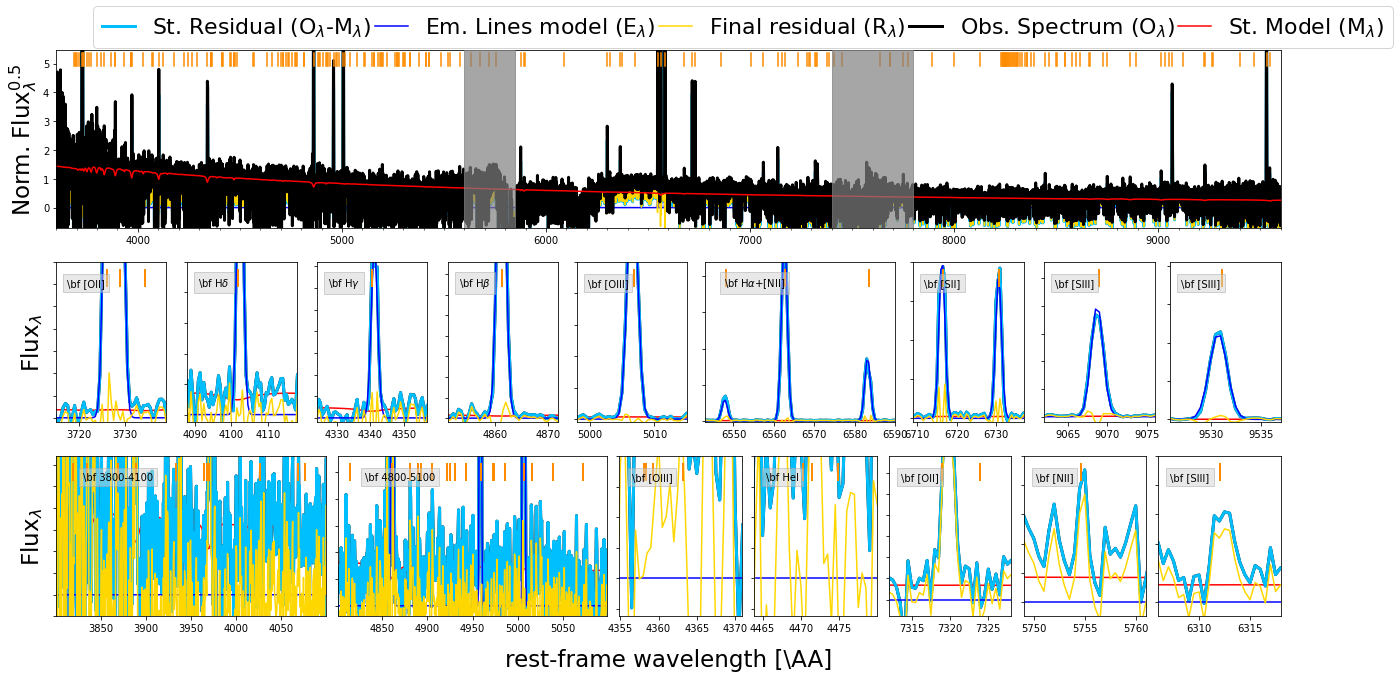

In [12]:
#############################################################################
#  
# Plotting the results of the fitting of the integarted spectrum RSP+EL
#
#############################################################################

if config.get("do_plots", 0) == 1:
    tab_el = read_tab_EL(config["emission_lines_file_long"])
    y_off = -1.09
    y_off2 = -2.18
    plot_spec_art(dir='',
                  file=out_files["fit"],
                  file_ssp=out_files["rsp"],
                  name=config["label"],
                  output=f"{output_dir}/plot_m_{config['label']}.pdf",
                  c_map='CMRmap',\
                  insets=((0.00, y_off, 0.09, 0.9,3715,3739,-1,35,'[OII]'),\
                          (0.107, y_off, 0.09, 0.9,4088,4118,-0.5,10,r'H$\delta$'),\
                          (0.213, y_off, 0.09, 0.9,4324,4357,-0.5,18,r'H$\gamma$'),\
                          (0.320, y_off, 0.09, 0.9,4851,4872,-1.0,38,r'H$\beta$'),\
                          (0.425, y_off, 0.09, 0.9,4998,5015,-1.0,50,'[OIII]'),\
                          (0.530, y_off, 0.155, 0.9,6543,6590,-2,220,r'H$\alpha$+[NII]'),\
                          (0.700, y_off, 0.09, 0.9,6709,6737,-0.5,20,'[SII]'),\
                          (0.807, y_off, 0.09, 0.9,9062,9076,-1.0,28,'[SIII]'),\
                          (0.910, y_off, 0.09, 0.9,9526,9537,-1.5,82,'[SIII]'),\
                          (0.00, y_off2, 0.22, 0.9,3801,4099,-0.5,3.2,'3800-4100'),\
                          (0.23, y_off2, 0.22, 0.9,4801,5099,-0.2,2.8,'4800-5100'),\
                          (0.46, y_off2, 0.10, 0.9,4363-8.1,4363+7.9,-0.25,0.8,'[OIII]'),\
                          (0.57, y_off2, 0.10, 0.9,4472-8.1,4472+7.9,-0.25,0.8,'HeI'),\
                          (0.68, y_off2, 0.10, 0.9,7320-8,7320+8,-0.2,1.7,'[OII]'),\
                          (0.79, y_off2, 0.10, 0.9,5755-6,5755+6,-0.25,2.5,'[NII]'),\
                          (0.90, y_off2, 0.10, 0.9,6312-6,6312+6,-0.25,2.5,'[SIII]')
                         ),
                      y_min=-0.5,y_max=30,y0_d=0.3,y1_d=2.9,\
                      x_min=3600,x_max=9600,plot_el=True, tab_el=tab_el,plot_res=True,\
                      show_scale=False,n_ord=2,gamma=0.5)#,x_min=3600,x_max=9600)



1 12401 1
215 emission lines
0 HI 3686.83
1 HI 3691.56
2 HI 3697.15
3 HI 3703.85
4 HI 3711.97
5 [OII] 3726.03
6 [OII] 3728.82
7 HI 3734.37
8 HI 3750.15
9 [FeVII] 3758.9
10 HI 3770.63
11 HI 3797.9
12 HeI 3819.61
13 HI 3835.38
14 [NeIII] 3868.75
15 HeI 3888.65
16 HI 3889.05
17 CaII 3933.66
18 HeI 3964.73
19 [NeIII] 3967.46
20 CaII 3968.47
21 Hepsilon 3970.07
22 HeI 4026.19
23 [SII] 4068.6
24 [SII] 4076.35
25 Hdelta 4101.77
26 HeI 4120.81
27 [FeII] 4177.21
28 [FeV] 4227.2
29 [FeII] 4243.98
30 CII 4267.0
31 [FeII] 4287.4
32 Hgamma 4340.49
33 [FeII] 4358.1
34 [FeII] 4358.37
35 [FeII] 4359.34
36 [OIII] 4363.21
37 [FeII] 4413.78
38 [FeII] 4414.45
39 [FeII] 4416.27
40 [FeII] 4452.11
41 [FeII] 4457.95
42 [FeII] 4470.29
43 HeI 4471.48
44 [FeII] 4474.91
45 [NiII] 4485.21
46 [MgI] 4562.48
47 MgI] 4571.1
48 [FeII] 4632.27
49 [FeIII] 4658.1
50 HeII 4685.68
51 [FeIII] 4701.62
52 [ArIV] 4711.33
53 HeI 4713.14
54 [NeIV] 4724.17
55 [FeIII] 4733.93
56 [ArIV] 4740.2
57 [FeIII] 4754.83
58 [FeIII] 4769.6
59

129/215, 6730.82,[SII] blended: 0 DONE
130/215, 6855.18,FeI blended: 0 DONE
131/215, 7005.67,[ArV] blended: 0 DONE
132/215, 7065.19,HeI blended: 0 DONE
133/215, 7135.8,[ArIII] blended: 0 DONE
134/215, 7155.14,[FeII] blended: 0 DONE
135/215, 7171.98,[FeII] blended: 0 DONE
136/215, 7236.0,CII blended: 0 DONE
137/215, 7281.35,HeI blended: 0 DONE
138/215, 7290.42,[FeI] blended: 1 DONE
139/215, 7291.46,[CaII] blended: 1 DONE
140/215, 7318.92,[OII] blended: 0 DONE
141/215, 7323.88,[CaII] blended: 0 DONE
142/215, 7329.66,[OII] blended: 0 DONE
143/215, 7377.83,[NiII] blended: 0 DONE
144/215, 7388.16,[FeII] blended: 0 DONE
145/215, 7411.61,[NiII] blended: 0 DONE
146/215, 7452.5,[FeII] blended: 0 DONE
147/215, 7637.52,[FeII] blended: 0 DONE
148/215, 7686.19,[FeII] blended: 1 DONE
149/215, 7686.9,[FeII] blended: 1 DONE
150/215, 7751.06,[ArIII] blended: 0 DONE
151/215, 7774.0,OI blended: 0 DONE
152/215, 7891.8,[FeXI] blended: 0 DONE
153/215, 7999.85,[CrII] blended: 0 DONE
154/215, 8125.22,[CrII] b

<IPython.core.display.Javascript object>


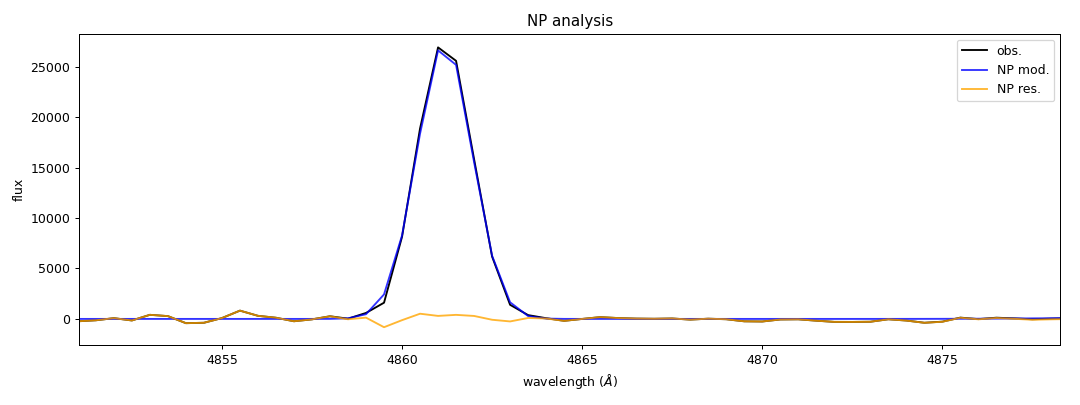

📊 Emission line table saved to: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/m_orion_all_nb.fe.ecsv


In [13]:
######################################################################
#
# Non-parametric analysis of the emission lines for the RSP-subtracted
# integrated spectrum (gas-pure spectrum)
#
######################################################################

# Prepare model outputs
%matplotlib notebook
#config["do_plots"]=1
config["do_plots"]=1
config["plot"]=1
plot = 1
do_plots = 1

#%matplotlib inline

out_model = np.array(SPS.output_spectra_list)
gas = out_model[0] - out_model[1]
smooth = median_filter(gas, size=config.get("smooth_size", 21))
l_smooth = fit_legendre_polynomial(wl, smooth, config.get("n_leg", 51))

out_model[2] += l_smooth
out_model[3] = out_model[0] - (out_model[1] + l_smooth)
out_model[4] = out_model[0] - out_model[2]

# Prepare single-RSS input for flux_elines
m_flux_rss = np.expand_dims(out_model[0] - out_model[1] - l_smooth, axis=0)
m_e_flux_rss = np.expand_dims(int_eflux, axis=0)
m_s_flux_rss = np.expand_dims(out_model[1] + l_smooth, axis=0)

vel__yx = np.zeros(1) + config["redshift"][0] * __c__
sigma__yx = config.get("sigma_gas", 0.8)
sigma__yx = 0.86
# Read emission lines again
tab_el = read_tab_EL(config["emission_lines_file_long"])

#
# We find the nearest emission line
#
lsf = []
blended = []
for wl_el in tab_el['wl']:
    i_wl_el = find_closest_indices(wl, wl_el)
    lsf_now = LSF_mean[i_wl_el[0]]
    lsf.append(lsf_now)
    i_wl_near = find_closest_indices_different(tab_el['wl'], wl_el)
    dist_abs = np.abs(wl_el-tab_el['wl'][i_wl_near[0]])
    if (dist_abs<4*sigma__yx):
        blended.append(1)
    else:
        blended.append(0)
blended = np.array(blended)    
tab_el['blended'] = blended
lsf = np.array(lsf)
tab_el['lsf'] = lsf
sigma_we = 1.0

#tab_el['lsf'] = 0.86
#print(np.sqrt(tab_el['lsf']**2+sigma__yx**2))

#tab_el['lsf'] = None
#sigma_we = 0.5

# Run flux_elines
fe_data, fe_hdr = flux_elines_RSS_EW_cl(
    m_flux_rss, hdr_flux, 5, tab_el, vel__yx, sigma__yx,
    eflux__wyx=m_e_flux_rss, flux_ssp__wyx=m_s_flux_rss,
    w_range=config.get("w_range_FE", 30),
    plot=config.get("do_plots", 0), sigma_we = sigma_we
)

# Convert to Astropy Table and save
colnames = [f"{fe_hdr[f'NAME{i}']}_{fe_hdr[f'WAVE{i}']}".replace(" ", "_") for i in range(fe_data.shape[0])]
tab_fe = Table(np.transpose(fe_data), names=colnames)
tab_fe.write(out_files["fe"], overwrite=True, delimiter=',')
print(f"📊 Emission line table saved to: {out_files['fe']}")



In [13]:
#######################################################
#
# We remove the option to plot all figures
#
#######################################################
config["do_plot"] = 0
config["plot"] = 0


In [ ]:
###########################################################
#
# Starting full RSS fitting for all spaxels
#
###########################################################


print("🚀 Starting full RSS fitting for all spaxels...\n")

out_file_fe = os.path.join(config["output_path"], f"{label}.fe.txt")
out_file_elines = os.path.join(config["output_path"], f"{label}.elines.txt")
out_file_kel = os.path.join(config["output_path"], f"{label}.kel.txt")
out_file_single = os.path.join(config["output_path"], f"{label}.single.txt")
out_file_coeffs = os.path.join(config["output_path"], f"{label}.coeffs.txt")
out_file_fit = os.path.join(config["output_path"], f"{label}.output.fits.gz")
out_file_ps = os.path.join(config["output_path"], f"{label}.rsp.txt")
out_file_dap = os.path.join(config["output_path"], f"{label}.dap.fits.gz")

# remove previous outputs with the same label
if (config["clear_outputs"]):
    clean_preview_results_files(out_file_ps, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
    clean_preview_results_files(out_file_fe, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
    clean_preview_results_files(out_file_dap, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)
    clean_preview_results_files(out_file_kel, out_file_elines, out_file_single, out_file_coeffs, out_file_fit)



rss_flux_masked = rss_flux[pt_table['mask']]
rss_eflux_masked = rss_eflux[pt_table['mask']]
tab_PT_masked = pt_table[pt_table['mask']]
tab_PT = tab_PT_masked 

model_spectra = []
y_ratio = None
nspec = rss_flux_masked.shape[0]

# Reuse the SPS from integrated spectrum as starting point
SPS_master = SPS

for i, (f__w, ef__w) in enumerate(zip(rss_flux_masked, rss_eflux_masked)):
    print(f"\n### Fitting spaxel {i+1}/{nspec} (ID: {tab_PT_masked['id'][i]})")

    #
    # printing some values
    #
    # print(SPS.best_redshift)
    # print(SPS.best_sigma)
    # print(SPS.best_AV)

    cf = SPS.config
    cf.redshift = SPS.best_redshift
    cf.sigma = SPS.best_sigma
    cf.AV = SPS.best_AV
    spaxel_label = f"{config['label']}_{i}"
    
    _, SPS = auto_rsp_elines_rnd(
        wl__w=wl, f__w=f__w, ef__w=ef__w,
        ssp_file=config["rsp_file"],
        ssp_nl_fit_file=config["rsp_nl_file"],
        config_file=config["config_file"],
        w_min=config["w_range"][0], w_max=config["w_range"][1],
        nl_w_min=config["w_range_nl"][0], nl_w_max=config["w_range_nl"][1],
        mask_list=config.get("mask_file"),
        min=config["flux_scale"][0], max=config["flux_scale"][1],
        elines_mask_file=config.get("emission_lines_file"),
        fit_gas=not config.get("ignore_gas", False),
        refine_gas=not config.get("single_gas_fit", False),
        sigma_gas=config.get("sigma_gas", 3.0),
        input_redshift=config["redshift"][0],
        delta_redshift=config["redshift"][1],
        min_redshift=config["redshift"][2],
        max_redshift=config["redshift"][3],
        input_sigma=config["sigma"][0],
        delta_sigma=config["sigma"][1],
        min_sigma=config["sigma"][2],
        max_sigma=config["sigma"][3],
        input_AV=config["AV"][0],
        delta_AV=config["AV"][1],
        min_AV=config["AV"][2],
        max_AV=config["AV"][3],
        sigma_inst=config["sigma_inst"],
        spaxel_id=spaxel_label,
        out_path=config["output_path"],
        plot=config.get("plot", 0),
        SPS_master=SPS_master,
        SN_CUT=config.get("SN_CUT", 3)
    )

    SPS.output_gas_emission(filename=f"{output_dir}/{config['label']}.elines.txt", spec_id=i)
    SPS.output_coeffs_MC(filename=f"{output_dir}/{config['label']}.coeffs.txt", write_header=(i == 0))

    try:
        SPS.output(filename=f"{output_dir}/{config['label']}.rsp.txt", write_header=(i == 0), block_plot=False)
    except Exception as e:
        print(f"⚠️ Warning: Failed to write spaxel {i} summary output. Filling with NaNs.")
        pass

    model_spectra.append(SPS.output_spectra_list)


🚀 Starting full RSS fitting for all spaxels...


### Fitting spaxel 1/174 (ID: 6560.3)
# Using predefined configuration file for the emission lines
##############################
# START: fitting the continuum+emission lines, fit_gas:True ...
-> median error in flux = 501.9715
-> median raw flux = 106.6940 - Warning: no cut (CUT_MEDIAN_FLUX = 0)
Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.02802499292227
-> MED_FLUX : 581.1915893554688 +- 855.5464348733257 SN:1.02802499292227
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0075 |        0.00

-> number of models = 2 | chi^2 = 0.2188763345597364
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 33941.2157 +/- 898.4092 |    0.8023 +/-  0.0211 |   -9.1145 +/-  1.2100 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  104.9215 +/- 43.7048 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.22763209212474253
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 2512.4886 +/- 654.0646 |    1.0000 +/-  0.0676 |    1.3457 +/- 13.0089 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   66.5426 +/- 11.5329 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of mo

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.21687006775222573
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 11664.1203 +/- 468.6639 |    0.6714 +/-  0.0407 |   -8.5072 +/-  5.5199 |
| eline | 6716.4400 +/-  0.0000 | 14406.0629 +/- 586.0305 |    0.6714 +/-  0.0407 |   -8.5072 +/-  5.5199 |
-----------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 0.45294870722

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.7433084255286457
-> MED_FLUX : 38.8272705078125 +- 955.5815852461704 SN:0.7433084255286457
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0070 |  3.7506 |  4.3738 | -0.1360 | 0.1133 |      0.0069 |        0.0073 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0070 |  3.7506 |  4.3738 | -0.1360 |  0.1133 | 0.0000 |    0.0000 |  13.6564 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.5730941873735225
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 13002.6077 +/- 1090.2590 |    0.7668 +/-  0.0008 |   40.9874 +/-  1.9443 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  304.0212 +/- 38.4196 |
----------------------------------
-> analyzing 2 models in 6260-6330 w

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.9160812044796468
-> MED_FLUX : 541.7381591796875 +- 974.7561341064361 SN:0.9160812044796468
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0062 |        0.0066 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.23507313019033524
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 7404.5388 +/- 403.0807 |    0.6601 +/-  0.0390 |   -4.4890 +/-  2.7435 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   13.5298 +/- 13.5433 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of mo

-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.48395838359837656
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 42876.7752 +/- 1093.4669 |    0.7532 +/-  0.0040 |  -11.4813 +/-  3.3528 |
| eline | 4958.9100 +/-  0.0000 | 14277.9661 +/- 843.5479 |    0.7532 +/-  0.0040 |  -11.4813 +/-  3.3528 |
| eline | 4861.3600 +/-  0.0000 | 56387.9808 +/- 1165.4618 |    0.7532 +/-  0.0040 |  -11.4813 +/-  3.3528 |
------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8718002004908771
-> MED_FLUX : 521.687255859375 +- 847.3630661897525 SN:0.8718002004908771
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0089 |        0.0090 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.2433480164523784
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 3436.7187 +/- 284.2322 |    0.4252 +/-  0.0974 |   -3.9379 +/-  3.5820 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  127.8976 +/- 14.3315 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of mod

-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.6387417500079644
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 92185.7869 +/- 2087.2118 |    0.7285 +/-  0.0315 |  -12.3044 +/-  1.5121 |
| eline | 4958.9100 +/-  0.0000 | 30697.8670 +/- 1061.7851 |    0.7285 +/-  0.0315 |  -12.3044 +/-  1.5121 |
| eline | 4861.3600 +/-  0.0000 | 91975.2306 +/- 2844.7855 |    0.7285 +/-  0.0315 |  -12.3044 +/-  1.5121 |
------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8912021985142192
-> MED_FLUX : 537.0279541015625 +- 1011.8369127948666 SN:0.8912021985142192
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0072 |        0.0073 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.264704551548083
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 58212.1954 +/- 1230.1218 |    0.8056 +/-  0.0182 |  -10.0915 +/-  1.3218 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  145.7481 +/- 42.7981 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.18003216981904652
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 4381.0247 +/- 734.5522 |    1.0798 +/-  0.2828 |   -3.8155 +/-  4.3537 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -80.9075 +/- 12.1272 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of mo

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.4143115579351639
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 11775.7127 +/- 554.5156 |    0.6499 +/-  0.0133 |   -6.5254 +/-  1.3420 |
| eline | 6716.4400 +/-  0.0000 | 16818.3194 +/- 641.3639 |    0.6499 +/-  0.0133 |   -6.5254 +/-  1.3420 |
-----------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 325
-> number of models = 3 | chi^2 = 0.593576426045

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8370843477723635
-> MED_FLUX : 356.9569091796875 +- 1008.4779231251468 SN:0.8370843477723635
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0087 |        0.0087 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi

-> number of models = 2 | chi^2 = 0.24361801268422353
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 36028.9973 +/- 1066.9937 |    0.7953 +/-  0.0229 |   -6.9626 +/-  6.1258 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  131.8139 +/- 23.5141 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.21032624530618496
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 4854.3301 +/- 458.6154 |    0.5130 +/-  0.0000 |    1.6251 +/-  2.9839 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -29.9557 +/- 19.5749 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of mo

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.2566917623329355
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 7107.4611 +/- 734.0513 |    0.6662 +/-  0.0205 |   -3.3001 +/-  4.5427 |
| eline | 6716.4400 +/-  0.0000 | 8525.4850 +/- 494.8821 |    0.6662 +/-  0.0205 |   -3.3001 +/-  4.5427 |
----------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 1.030722761274366
  

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.9469551321203866
-> MED_FLUX : 521.56689453125 +- 762.3473708215294 SN:0.9469551321203866
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0088 |        0.0088 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 300
-> number of models = 3 | chi^2 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 0.6502068671057503
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 6067.9824 +/- 1302.7946 |    0.8436 +/-  0.0684 |   78.1930 +/-  1.8223 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -71.7479 +/-  9.0976 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.242883

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8156654256190743
-> MED_FLUX : 289.33953857421875 +- 882.7351851197915 SN:0.8156654256190743
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0039 |  3.8301 |  3.9344 | 0.0449 | 0.0469 |      0.0040 |        0.0042 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.16835248346261558
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 23412.3971 +/- 814.8869 |    0.7815 +/-  0.0000 |   -5.6400 +/-  3.6515 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   23.1033 +/- 32.8961 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.5752987320240613
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 8071.6637 +/- 1122.3175 |    0.7571 +/-  0.0112 |   54.6088 +/-  4.8394 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   83.8465 +/- 26.6440 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number o

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.7354853848508387
-> MED_FLUX : 124.03956604003906 +- 871.5742155395128 SN:0.7354853848508387
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0094 |  3.5370 |  0.7488 | -0.3376 | 0.0959 |      0.0092 |        0.0115 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.2513748533907362
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 19199.9362 +/- 845.0077 |    0.8131 +/-  0.0134 |   -0.4783 +/-  3.1821 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -481.2409 +/- 33.1591 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coe

-> real number of loops = 250
-> number of models = 2 | chi^2 = 0.6019848244533306
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 5380.4810 +/- 994.1724 |    0.7294 +/-  0.1186 |   38.2101 +/- 10.2818 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  120.5951 +/- 10.9453 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of mode

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8289344314283326
-> MED_FLUX : 356.314208984375 +- 1005.4589287009836 SN:0.8289344314283326
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0101 |  3.9999 |  3.5705 | -0.8914 | 0.1969 |      0.0046 |        0.0047 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.1634368768515632
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 18220.4906 +/- 773.6784 |    0.7898 +/-  0.0000 |   -2.7056 +/-  1.3383 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   55.4059 +/- 30.9458 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coe

-> number of models = 2 | chi^2 = 0.8989547055499154
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 6343.4405 +/- 2195.8921 |    1.2503 +/-  0.1007 |   59.9976 +/-  7.4300 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -186.4037 +/- 34.5542 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.234902

len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0039 |  3.8301 |  3.9344 | 0.0449 | 0.0469 |      0.0035 |        0.0034 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.2880864178035836
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
--------------------------------------------------------------------------------------------

-> number of models = 2 | chi^2 = 0.2326368348838634
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 18430.1973 +/- 1126.0233 |    0.8838 +/-  0.0525 |   -2.3686 +/-  2.0180 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -107.3966 +/- 24.1788 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
--------------------

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.20573495239616935
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 3745.8389 +/- 364.4271 |    0.4721 +/-  0.0231 |   -4.3120 +/-  3.1880 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   98.0176 +/-  8.9303 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 225
-> number of mo

-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.5633795371874886
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 41501.9906 +/- 1127.0779 |    0.7696 +/-  0.0199 |  -12.8313 +/-  3.0549 |
| eline | 4958.9100 +/-  0.0000 | 13820.1629 +/- 942.3263 |    0.7696 +/-  0.0199 |  -12.8313 +/-  3.0549 |
| eline | 4861.3600 +/-  0.0000 | 20772.1781 +/- 1031.5438 |    0.7696 +/-  0.0199 |  -12.8313 +/-  3.0549 |
------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.6

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.800812938612233
-> MED_FLUX : 278.4013671875 +- 931.5435560019545 SN:0.800812938612233
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0066 |        0.0068 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 0

-> number of models = 2 | chi^2 = 0.19036367522268982
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 29197.2077 +/- 681.0510 |    0.8198 +/-  0.0251 |   -4.8073 +/-  1.5245 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   43.0240 +/- 17.0267 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
------------------------

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.22031693637762104
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 4028.7541 +/- 497.0987 |    0.5197 +/-  0.1057 |    3.6487 +/-  6.7875 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -16.1664 +/-  5.5075 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of mo

-> real number of loops = 225
-> number of models = 3 | chi^2 = 3.290469333650538
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 89402.4814 +/- 2894.1786 |    0.8774 +/-  0.0000 |  -19.3106 +/-  1.5049 |
| eline | 4958.9100 +/-  0.0000 | 29771.0263 +/- 2779.8872 |    0.8774 +/-  0.0000 |  -19.3106 +/-  1.5049 |
| eline | 4861.3600 +/-  0.0000 | 76702.5772 +/- 2939.2117 |    0.8774 +/-  0.0000 |  -19.3106 +/-  1.5049 |
------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.6

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.2170090297839904
-> MED_FLUX : 853.533935546875 +- 919.1365960589418 SN:1.2170090297839904
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0054 |        0.0057 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.3594114718744054
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 89169.4033 +/- 961.1258 |    0.8247 +/-  0.0000 |   -6.8359 +/-  3.3718 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -77.4923 +/- 39.9634 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coe

-> real number of loops = 250
-> number of models = 2 | chi^2 = 0.38386110275439644
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 36931.4389 +/- 1018.9861 |    0.7439 +/-  0.0150 |   49.5490 +/-  1.3906 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   82.7684 +/- 35.9053 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> nu

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8644018282684136
-> MED_FLUX : 687.6358642578125 +- 1020.94894968281 SN:0.8644018282684136
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0066 |        0.0066 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.2640977554620836
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 41232.1016 +/- 1001.2180 |    0.8541 +/-  0.0316 |   -5.8080 +/-  2.0074 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.4471 +/- 43.2812 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Er

-> real number of loops = 150
-> number of models = 2 | chi^2 = 1.6055654722303592
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 25508.8486 +/- 2207.4510 |    0.9921 +/-  0.0226 |   35.8223 +/-  4.1747 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -209.1773 +/- 36.9421 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> num

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.9790566088771059
-> MED_FLUX : 447.41156005859375 +- 912.4675155487283 SN:0.9790566088771059
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0086 |        0.0085 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 250
-> number of models = 3 | chi

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.49710098725802176
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 25222.0889 +/- 1278.8250 |    0.8565 +/-  0.0179 |   43.9484 +/-  2.1386 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -109.4489 +/- 55.0273 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> num

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.0411430439060383
-> MED_FLUX : 927.5958251953125 +- 755.5985348627695 SN:1.0411430439060383
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0055 |        0.0056 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.92390170519724
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 17578.6149 +/- 1417.5394 |    0.7620 +/-  0.0679 |   46.2505 +/-  4.3720 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -657.5932 +/- 44.8978 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.800958213869178
-> MED_FLUX : 262.3793640136719 +- 820.0874326652123 SN:0.800958213869178
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0039 |  3.8301 |  3.9344 | 0.0449 | 0.0469 |      0.0068 |        0.0066 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 =

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.22770193908209557
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 35847.5942 +/- 766.2719 |    0.8314 +/-  0.0340 |  -11.1044 +/-  1.1591 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   53.5575 +/- 38.6237 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.7286315255358551
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 13723.8826 +/- 1084.3528 |    0.7916 +/-  0.0000 |   40.4970 +/-  1.6173 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -40.3914 +/- 44.5855 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8370245039233662
-> MED_FLUX : 327.4548034667969 +- 867.6572678704089 SN:0.8370245039233662
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0074 |        0.0071 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.23471830497488633
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 29143.1075 +/- 822.7514 |    0.8222 +/-  0.0242 |   -9.9142 +/-  1.0665 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  123.9653 +/- 28.2130 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> real number of loops = 150
-> number of models = 2 | chi^2 = 1.0131099449709027
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 12600.1003 +/- 1358.8905 |    0.7514 +/-  0.0185 |   47.2284 +/-  1.3798 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -174.6328 +/- 52.5116 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8539691683031602
-> MED_FLUX : 393.8263854980469 +- 834.4229677598623 SN:0.8539691683031602
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0072 |        0.0074 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.20562224130630433
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 29786.0912 +/- 918.4033 |    0.8091 +/-  0.0964 |   -9.5180 +/-  7.9648 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   24.1535 +/- 12.5010 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.506658641069816
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 21992.3136 +/- 1455.5470 |    0.7625 +/-  0.0572 |   42.0122 +/-  3.7428 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -242.1361 +/- 41.4410 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8059689897597483
-> MED_FLUX : 380.97216796875 +- 903.5358856196898 SN:0.8059689897597483
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0073 |        0.0075 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 0.228013364618779
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 3411.4539 +/- 591.8098 |    1.0000 +/-  0.0000 |  -10.3784 +/- 10.8040 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -30.2784 +/- 18.2192 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 6.84134684353

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.4993864845239375
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 8014.7511 +/- 842.8211 |    0.6453 +/-  0.0214 |   -5.4444 +/-  1.7161 |
| eline | 6716.4400 +/-  0.0000 | 15875.1352 +/- 801.2898 |    0.6453 +/-  0.0214 |   -5.4444 +/-  1.7161 |
-----------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.4642980531055591

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8708241750867002
-> MED_FLUX : 135.0439910888672 +- 950.532564661463 SN:0.8708241750867002
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0074 |        0.0073 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.22203022703553726
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 35803.0954 +/- 658.8709 |    0.8083 +/-  0.0136 |  -10.9636 +/-  3.3551 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   24.4857 +/- 28.2911 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> real number of loops = 250
-> number of models = 2 | chi^2 = 0.9784799568489906
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 21725.5481 +/- 1599.5987 |    0.8341 +/-  0.0357 |   61.1842 +/-  1.6600 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -54.0565 +/- 28.6920 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> num

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.7735284650454735
-> MED_FLUX : 559.610107421875 +- 918.2971522873813 SN:0.7735284650454735
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0083 |        0.0082 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2

-> number of models = 2 | chi^2 = 0.1774756706044192
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 37554.1792 +/- 585.9307 |    0.8238 +/-  0.0382 |  -11.1776 +/-  1.4053 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   86.6407 +/- 35.1257 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.15839599496988913
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 7130.4829 +/- 582.1457 |    0.6321 +/-  0.0820 |   -4.3322 +/- 12.6307 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   63.9454 +/- 24.6452 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of mo

-> real number of loops = 150
-> number of models = 2 | chi^2 = 1.239498835098231
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 14145.5549 +/- 1238.2629 |    0.6888 +/-  0.0051 |   -9.0545 +/-  5.2413 |
| eline | 6716.4400 +/-  0.0000 | 16260.9681 +/- 1212.3054 |    0.6888 +/-  0.0051 |   -9.0545 +/-  5.2413 |
------------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 1.1385788

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8246882081881847
-> MED_FLUX : 356.9692687988281 +- 834.4230267867393 SN:0.8246882081881847
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0090 |        0.0091 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 0.18105541297812233
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 5052.8978 +/- 661.8336 |    0.6051 +/-  0.0291 |    1.8730 +/-  2.7128 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  162.9276 +/- 15.1069 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 8.604092034

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.312642383825435
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 15075.7293 +/- 550.0311 |    0.6470 +/-  0.0000 |   -7.5087 +/-  1.5865 |
| eline | 6716.4400 +/-  0.0000 | 21561.4428 +/- 555.8022 |    0.6470 +/-  0.0000 |   -7.5087 +/-  1.5865 |
-----------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 1.1675685795029

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8960954895652087
-> MED_FLUX : 549.3341674804688 +- 878.1622269132382 SN:0.8960954895652087
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0081 |        0.0079 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.402929088788997
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 71498.4617 +/- 1944.5090 |    0.7943 +/-  0.0503 |  -13.4286 +/-  1.5848 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.9110 +/- 33.5968 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err

-> real number of loops = 175
-> number of models = 2 | chi^2 = 1.8234956117236338
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 29368.0121 +/- 2640.8946 |    1.1549 +/-  0.0571 |   54.8550 +/-  4.6679 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -232.7370 +/- 46.4999 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> num

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8743376462376569
-> MED_FLUX : 359.74346923828125 +- 1056.2453009558049 SN:0.8743376462376569
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0080 |        0.0080 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | ch

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.29463748986138877
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 52614.7427 +/- 819.3165 |    0.7867 +/-  0.0024 |   -8.0260 +/-  2.6085 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  187.2296 +/- 47.3526 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.9033410862562502
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 24614.3496 +/- 1348.6645 |    0.7481 +/-  0.0000 |   57.3106 +/-  2.0274 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    9.1634 +/- 27.7497 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.233841739723195
-> MED_FLUX : 1028.099365234375 +- 866.811785794167 SN:1.233841739723195
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0067 |        0.0068 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 =

-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   37.9770 +/- 26.7183 |
----------------------------------
-> analyzing 2 models in 9500-9570 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
9531.1 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.4456123499613954
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 102444.1519 +/- 2292.4248 |    0.7835 +/-  0.0006 |   -6.4184 +/-  3.8265 |
---------------------------------

----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 2 | chi^2 = 1.5600525072974076
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 18440.7599 +/- 1834.6717 |    0.8069 +/-  0.0282 |   32.6505 +/-  4.1051 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -193.9241 +/- 33.5913 |
----------------------------------
-

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.171851906363553
-> MED_FLUX : 1070.110595703125 +- 1080.3525280554557 SN:1.171851906363553
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0054 |        0.0059 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 2 | chi^2 = 1.1056965470816
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 14271.8750 +/- 1547.4533 |    0.8375 +/-  0.0618 |   43.1310 +/-  4.2069 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -460.6347 +/- 31.3588 |
----------------------------------
-> analyzing 2 models in 6260-6330 wave

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8832265964211263
-> MED_FLUX : 448.87969970703125 +- 943.7729882099374 SN:0.8832265964211263
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0010 |  3.7582 |  3.8673 | -0.0078 | 0.0931 |      0.0048 |        0.0049 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0010 |  3.7582 |  3.8673 | -0.0078 |  0.0931 | 0.0000 |    0.0000 |  13.2591 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 300
-> number of models = 2 | chi^2 = 0.20243858896174985
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 |   13.6905 +/- 278.3342 |    0.5649 +/-  0.3390 | -107.6813 +/-  6.1947 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -72.8246 +/-  4.2290 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of mo

-> number of models = 2 | chi^2 = 0.30528920220607275
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 4924.4486 +/- 634.9898 |    0.7926 +/-  0.0081 |    0.0337 +/-  5.0095 |
| eline | 6716.4400 +/-  0.0000 | 4265.7750 +/- 539.0160 |    0.7926 +/-  0.0081 |    0.0337 +/-  5.0095 |
----------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 250
-> number of models = 3 | chi^2 = 0.5379184011474505
        ----------------------

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.6542705823532853
-> MED_FLUX : 159.174560546875 +- 931.6838604234653 SN:0.6542705823532853
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0090 |        0.0088 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.8066059732508569
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 5171.1005 +/- 1378.3007 |    0.9024 +/-  0.0436 |   79.8609 +/-  3.4833 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  577.4966 +/- 12.2288 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8961953674128644
-> MED_FLUX : 612.0855102539062 +- 901.9214562631852 SN:0.8961953674128644
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0086 |        0.0093 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.25271353319698786
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 27736.1737 +/- 699.5363 |    0.8521 +/-  0.0000 |   -4.5668 +/-  3.8864 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  157.5700 +/- 14.3629 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.5357499308139811
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 24090.3612 +/- 1334.5509 |    0.7325 +/-  0.0520 |   49.8723 +/-  4.9268 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -212.9260 +/- 30.4681 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 225
-> num

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.9723167996607506
-> MED_FLUX : 848.9869995117188 +- 904.2242247366008 SN:0.9723167996607506
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0059 |  3.9896 |  3.4372 | -1.0824 | 0.1473 |      0.0065 |        0.0065 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0059 |  3.9896 |  3.4372 | -1.0824 |  0.1473 | 0.0000 |    0.0000 |  12.5171 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.28934989161346725
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 3803.5720 +/- 601.6011 |    0.5573 +/-  0.0000 |  -13.0035 +/-  7.9817 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  185.9348 +/- 18.6718 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of mo

-> number of models = 2 | chi^2 = 1.2462512963912513
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 16092.7816 +/- 1151.8792 |    0.4178 +/-  0.0248 |   10.6311 +/-  2.6821 |
| eline | 6716.4400 +/-  0.0000 | 22763.5049 +/- 1083.4551 |    0.4178 +/-  0.0248 |   10.6311 +/-  2.6821 |
------------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 1.3446945000534238
        -----------

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.9117147551795017
-> MED_FLUX : 1036.3004150390625 +- 809.547940511904 SN:1.9117147551795017
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0044 |        0.0043 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 250
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.2395758637316534
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 8268.7295 +/- 466.6434 |    0.5903 +/-  0.0000 |   -4.4588 +/-  1.4539 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  191.7246 +/- 20.7184 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of mod

-> number of models = 2 | chi^2 = 1.6702622458901653
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 18125.2711 +/- 2117.2010 |    1.0871 +/-  0.0063 |   -6.8630 +/-  2.7948 |
| eline | 6716.4400 +/-  0.0000 | 11405.9679 +/- 2127.5111 |    1.0871 +/-  0.0063 |   -6.8630 +/-  2.7948 |
------------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.6122480944439603
        -----------

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8201435693834098
-> MED_FLUX : 347.1533508300781 +- 823.8377405021641 SN:0.8201435693834098
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0043 |  3.6938 |  4.3314 | -0.3237 | 0.1084 |      0.0088 |        0.0090 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.38422397743631437
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 76568.0553 +/- 737.0172 |    0.8088 +/-  0.0148 |  -12.2314 +/-  0.8023 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -34.4501 +/- 16.0851 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.9808498558166093
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 22040.2749 +/- 1502.0947 |    0.8669 +/-  0.0580 |   42.4388 +/-  3.1476 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -277.3772 +/- 35.4283 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.7886057658720476
-> MED_FLUX : 239.56964111328125 +- 965.1098223654708 SN:0.7886057658720476
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0039 |  3.8301 |  3.9344 | 0.0449 | 0.0469 |      0.0073 |        0.0076 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.27846980563907936
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 55500.4955 +/- 1245.8905 |    0.8090 +/-  0.0250 |  -11.2819 +/-  1.2115 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    2.3712 +/- 42.6460 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | E

-> real number of loops = 125
-> number of models = 2 | chi^2 = 1.0824527314781758
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 14390.2358 +/- 1178.9726 |    0.6142 +/-  0.0402 |   52.9724 +/-  2.0707 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   84.5124 +/- 39.2297 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8062613958868801
-> MED_FLUX : 344.2425537109375 +- 834.8591993639877 SN:0.8062613958868801
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0079 |        0.0081 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 0.6832325892350043
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 14476.5860 +/- 1342.5388 |    0.9310 +/-  0.0000 |   71.7466 +/-  6.4179 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -261.0909 +/- 34.6390 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.2

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.7808939060165988
-> MED_FLUX : 117.30245208740234 +- 953.9622703028527 SN:0.7808939060165988
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0075 |        0.0077 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 |  0.0572 | 0.0000 |    0.0000 |  13.0617 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.8570383575755601
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 14651.9648 +/- 1154.9636 |    0.7237 +/-  0.0565 |   45.9888 +/-  2.1746 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -67.0188 +/- 59.6266 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.7544089923483405
-> MED_FLUX : 752.1633911132812 +- 945.1295174012624 SN:0.7544089923483405
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0088 |        0.0087 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 250
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.7698704821383252
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 12129.4485 +/- 1097.1652 |    0.6652 +/-  0.0411 |   45.3337 +/-  3.0551 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  230.4300 +/- 44.6315 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.7630400503922438
-> MED_FLUX : 147.7766571044922 +- 913.6244991942846 SN:0.7630400503922438
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0070 |        0.0068 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.23416873644018707
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 38908.8688 +/- 724.3785 |    0.7975 +/-  0.0000 |  -10.7336 +/-  3.1680 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -10.2817 +/- 44.1239 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> number of models = 2 | chi^2 = 0.5306789408405547
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 16751.3408 +/- 1006.3394 |    0.7267 +/-  0.0097 |   43.2429 +/-  3.2007 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -13.8166 +/- 23.4528 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.2

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.9694030978238436
-> MED_FLUX : 563.209716796875 +- 902.9329783462698 SN:0.9694030978238436
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0089 |  3.6071 |  4.6806 | -0.1604 | 0.0493 |      0.0085 |        0.0084 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0089 |  3.6071 |  4.6806 | -0.1604 |  0.0493 | 0.0000 |    0.0000 |  14.3849 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 0.22530772689249928
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 3647.9732 +/- 742.1837 |    0.5131 +/-  0.2017 |  -16.2285 +/- 12.4321 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  132.3263 +/- 20.6718 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 7.004105784

-> real number of loops = 150
-> number of models = 3 | chi^2 = 0.5529437765479093
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 48671.2570 +/- 1062.3373 |    0.7801 +/-  0.0212 |  -12.7353 +/-  1.9195 |
| eline | 4958.9100 +/-  0.0000 | 16207.5286 +/- 885.1640 |    0.7801 +/-  0.0212 |  -12.7353 +/-  1.9195 |
| eline | 4861.3600 +/-  0.0000 | 94539.2779 +/- 1629.1161 |    0.7801 +/-  0.0212 |  -12.7353 +/-  1.9195 |
------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.6

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 4.824184995230379
-> MED_FLUX : 3311.485595703125 +- 1197.727912185016 SN:4.824184995230379
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0069 |  3.8213 |  3.8265 | -0.0949 | 0.0572 |      0.0004 |        0.0004 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.2523277416176751
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 55191.9377 +/- 1396.0292 |    0.7772 +/-  0.0355 |   -9.9439 +/-  0.4410 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -210.4484 +/- 34.6689 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Er

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.32309238819662744
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 2145.7543 +/- 229.9924 |    0.3042 +/-  0.0359 |  -15.6592 +/-  2.8687 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   83.9645 +/- 23.5517 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of mo

-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.761655025328088
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 54748.1244 +/- 1272.0788 |    0.8214 +/-  0.0287 |  -12.5546 +/-  1.0077 |
| eline | 4958.9100 +/-  0.0000 | 18231.1254 +/- 951.6169 |    0.8214 +/-  0.0287 |  -12.5546 +/-  1.0077 |
| eline | 4861.3600 +/-  0.0000 | 112613.4505 +/- 2442.6495 |    0.8214 +/-  0.0287 |  -12.5546 +/-  1.0077 |
-------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.0501250198873482
-> MED_FLUX : 611.8294677734375 +- 998.4555007807796 SN:1.0501250198873482
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0089 |        0.0090 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 225
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.26493573551053556
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 4091.9624 +/- 444.5816 |    0.3360 +/-  0.0402 |   14.1886 +/-  2.9268 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  118.3752 +/- 12.8109 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of mo

-> number of models = 2 | chi^2 = 0.5053588417698599
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 20720.8600 +/- 977.3495 |    0.8507 +/-  0.0424 |   -5.5137 +/-  3.3566 |
| eline | 6716.4400 +/-  0.0000 | 13185.3233 +/- 1050.4605 |    0.8507 +/-  0.0424 |   -5.5137 +/-  3.3566 |
------------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 1.381397870314511
        ----------------

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.347325289152275
-> MED_FLUX : 1360.6356201171875 +- 916.923030659248 SN:1.347325289152275
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0077 |        0.0079 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 225
-> number of models = 3 | chi^2 = 8.55925193151305
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 98093.3412 +/- 3814.0974 |    0.7742 +/-  0.0000 |    2.1883 +/-  3.6218 |
|  eline | 3728.8200 +/-  0.0000 | 98421.8861 +/- 3983.1140 |    0.7742 +/-  0.0000 |    2.1883 +/-  3.6218 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -174.2139 +/- 73.1545 |
----------------------------------
-> analyzing 2 models in 9030-9100 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
gu

-> real number of loops = 200
-> number of models = 3 | chi^2 = 3.7653865841005265
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 83053.8159 +/- 2933.0102 |    0.8485 +/-  0.0000 |  -13.0927 +/-  1.6278 |
| eline | 4958.9100 +/-  0.0000 | 27656.9207 +/- 2821.7423 |    0.8485 +/-  0.0000 |  -13.0927 +/-  1.6278 |
| eline | 4861.3600 +/-  0.0000 | 99399.3896 +/- 2856.5035 |    0.8485 +/-  0.0000 |  -13.0927 +/-  1.6278 |
------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.1026948517096455
-> MED_FLUX : 963.45703125 +- 821.8110657171918 SN:1.1026948517096455
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0055 |        0.0060 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 225
-> number of models = 3 | chi^2 = 1

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.31461719470950006
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 49086.0994 +/- 741.0413 |    0.8084 +/-  0.0000 |   -5.9837 +/-  2.0243 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  199.3093 +/- 37.7284 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Co

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.4458936574006489
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 14290.2370 +/- 1037.5610 |    0.7907 +/-  0.0195 |   58.8908 +/-  2.4736 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -99.8065 +/- 39.3998 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> num

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.9792841214703872
-> MED_FLUX : 308.7740478515625 +- 859.3976185800418 SN:0.9792841214703872
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0057 |        0.0059 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 125
-> number of models = 3 | chi^2 = 7.091025172708428
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 26052.2405 +/- 3953.1216 |    0.9761 +/-  0.0397 |   20.9876 +/-  3.7610 |
|  eline | 3728.8200 +/-  0.0000 | 19864.3801 +/- 4013.1355 |    0.9761 +/-  0.0397 |   20.9876 +/-  3.7610 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -156.3153 +/- 78.7148 |
----------------------------------
-> analyzing 2 models in 9030-9100 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
g

-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.742954659649465
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 92238.3144 +/- 1805.9631 |    0.8044 +/-  0.0141 |  -16.5574 +/-  6.1001 |
| eline | 4958.9100 +/-  0.0000 | 30715.3587 +/- 1201.4898 |    0.8044 +/-  0.0141 |  -16.5574 +/-  6.1001 |
| eline | 4861.3600 +/-  0.0000 | 45838.9943 +/- 1246.0171 |    0.8044 +/-  0.0141 |  -16.5574 +/-  6.1001 |
------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.6

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.0659493309254606
-> MED_FLUX : 747.6062622070312 +- 934.3597599673036 SN:1.0659493309254606
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0074 |        0.0073 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 150
-> number of models = 3 | chi^2 = 10.337984332657564
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 54823.3896 +/- 5152.3502 |    0.9115 +/-  0.0396 |   -1.2542 +/-  2.0980 |
|  eline | 3728.8200 +/-  0.0000 | 98188.4222 +/- 5225.9297 |    0.9115 +/-  0.0396 |   -1.2542 +/-  2.0980 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d |  111.5464 +/- 102.8087 |
-----------------------------------
-> analyzing 2 models in 9030-9100 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list f

-> number of models = 2 | chi^2 = 1.1988221103571979
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 7932.7470 +/- 1833.0186 |    0.9922 +/-  0.0360 |  -16.5273 +/-  1.6582 |
| eline | 6716.4400 +/-  0.0000 | 13045.5425 +/- 1764.3090 |    0.9922 +/-  0.0360 |  -16.5273 +/-  1.6582 |
------------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 1.2271163589035718
        ---------------

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.3646544691192812
-> MED_FLUX : 1003.9469604492188 +- 899.8251500542807 SN:1.3646544691192812
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0068 |        0.0069 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 175
-> number of models = 2 | chi^2 = 1.3485553831204578
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 28682.5826 +/- 1681.0967 |    0.8683 +/-  0.0571 |   41.0516 +/-  5.6230 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -10.9788 +/- 23.4893 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8755240027187575
-> MED_FLUX : 605.23486328125 +- 1013.7958233607509 SN:0.8755240027187575
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0088 |        0.0089 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2

-> number of models = 2 | chi^2 = 0.7559580124581067
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 127591.4431 +/- 4258.1522 |    0.8199 +/-  0.0556 |  -12.0252 +/-  0.3145 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  140.5056 +/- 70.5553 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
---------------

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.9106248841421918
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 36665.2610 +/- 1453.3580 |    0.9425 +/-  0.0053 |   41.3069 +/-  2.1104 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -307.7250 +/- 25.9160 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> num

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.936303395171061
-> MED_FLUX : 225.75067138671875 +- 964.0156833555881 SN:0.936303395171061
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0085 |        0.0086 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 1.2046430209966492
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 17483.7864 +/- 1556.7956 |    0.7618 +/-  0.0141 |   42.8407 +/-  3.1564 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -263.0830 +/- 28.5825 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.2

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 4.6993570298640215
-> MED_FLUX : 2375.75048828125 +- 1102.162419677249 SN:4.6993570298640215
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 | 0.0881 |      0.0007 |        0.0007 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0079 |  3.8048 |  4.1086 | -0.1759 |  0.0881 | 0.0000 |    0.0000 |  13.0625 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 0.825911061956743
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 12681.6920 +/- 1676.7328 |    0.9973 +/-  0.1215 |   53.4312 +/- 11.0120 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -259.0126 +/- 19.6373 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.28

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8456778015572131
-> MED_FLUX : 508.9805603027344 +- 902.5944401269314 SN:0.8456778015572131
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0092 |        0.0092 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^

-> number of models = 2 | chi^2 = 0.5060280371860417
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 72170.8413 +/- 1998.8254 |    0.7982 +/-  0.0445 |   -9.2235 +/-  1.4924 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   77.6419 +/- 40.4652 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
--------------------

-> real number of loops = 125
-> number of models = 2 | chi^2 = 1.3576418873092568
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 25809.7515 +/- 2065.8294 |    0.9286 +/-  0.0293 |   65.6999 +/-  8.4525 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -24.9316 +/- 50.5169 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> num

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.766020637647514
-> MED_FLUX : 542.5145263671875 +- 1177.1570793564701 SN:0.766020637647514
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0083 |        0.0083 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.28002216411765596
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 |  793.0792 +/- 220.1989 |    0.2500 +/-  0.0085 |  -35.7497 +/-  2.4361 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  130.4811 +/-  7.2610 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of mo

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.37441818542651517
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 6398.6597 +/- 782.5477 |    0.8171 +/-  0.0378 |  -12.0290 +/-  2.7825 |
| eline | 6716.4400 +/-  0.0000 | 8575.0921 +/- 531.7253 |    0.8171 +/-  0.0378 |  -12.0290 +/-  2.7825 |
----------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 1.0214187675081716


Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.9756311079155414
-> MED_FLUX : 433.12139892578125 +- 979.8665868017224 SN:0.9756311079155414
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0083 |        0.0086 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.26027079921362717
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 1932.3224 +/- 293.5091 |    0.3899 +/-  0.2386 |  -17.7357 +/- 10.6427 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   77.9584 +/- 26.5337 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of mo

-> real number of loops = 225
-> number of models = 3 | chi^2 = 0.9390578829840482
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 53119.7030 +/- 1457.0463 |    0.7901 +/-  0.0264 |  -11.9376 +/-  0.6928 |
| eline | 4958.9100 +/-  0.0000 | 17688.8611 +/- 1220.2522 |    0.7901 +/-  0.0264 |  -11.9376 +/-  0.6928 |
| eline | 4861.3600 +/-  0.0000 | 97093.6953 +/- 2016.2986 |    0.7901 +/-  0.0264 |  -11.9376 +/-  0.6928 |
------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.803612288659362
-> MED_FLUX : 509.4986572265625 +- 947.9603824713876 SN:0.803612288659362
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0086 |        0.0086 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.21066948428238733
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -674.8126 +/- 820.3270 |    1.3186 +/-  0.2443 |   -4.5173 +/- 19.1108 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  148.7290 +/-  7.3847 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of mo

-> number of models = 2 | chi^2 = 2.021287352370595
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 7353.3012 +/- 2242.7108 |    1.0304 +/-  0.0166 |   -9.4549 +/-  5.8609 |
| eline | 6716.4400 +/-  0.0000 | 9101.5460 +/- 2194.5633 |    1.0304 +/-  0.0166 |   -9.4549 +/-  5.8609 |
-----------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 5.658858402125684
        -------------------

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8622342120316717
-> MED_FLUX : 558.1652221679688 +- 930.0819138242425 SN:0.8622342120316717
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0065 |        0.0065 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.3616224634526347
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 81415.0472 +/- 1722.4305 |    0.8283 +/-  0.0273 |  -10.1341 +/-  1.8372 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  121.5905 +/- 35.1833 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Er

-> real number of loops = 150
-> number of models = 2 | chi^2 = 1.37363735403815
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 43239.2170 +/- 2062.7092 |    0.7656 +/-  0.0456 |   33.4621 +/-  1.9924 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -62.0671 +/- 18.9898 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> numbe

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8528628856282942
-> MED_FLUX : 475.598876953125 +- 870.3842420265521 SN:0.8528628856282942
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0092 |        0.0092 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 0.2173548920378256
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 2005.9444 +/- 489.9417 |    0.6847 +/-  0.0040 |    0.6164 +/-  5.4270 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   34.9168 +/- 11.8444 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 10.055107167

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.9088526105223114
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 13039.9499 +/- 1727.0324 |    0.9082 +/-  0.0128 |  -12.7071 +/-  0.5729 |
| eline | 6716.4400 +/-  0.0000 | 13445.1418 +/- 1398.5507 |    0.9082 +/-  0.0128 |  -12.7071 +/-  0.5729 |
------------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of models = 3 | chi^2 = 0.678022

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.9541525023448695
-> MED_FLUX : 626.2047119140625 +- 837.6192622093467 SN:0.9541525023448695
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0084 |        0.0081 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 225
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 0.7590921443908032
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 52318.3037 +/- 1433.8440 |    0.7603 +/-  0.0000 |   48.5837 +/-  7.1905 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -365.4889 +/- 56.6932 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.3

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.1667280224049488
-> MED_FLUX : 916.1038818359375 +- 1101.4075609939223 SN:1.1667280224049488
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0082 |        0.0081 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.8006576852568559
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 114722.7959 +/- 2571.3928 |    0.8170 +/-  0.0306 |   -9.2574 +/-  1.3774 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   87.4541 +/- 68.8955 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.2363095915650259
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 1518.7066 +/- 609.1580 |    0.9549 +/-  0.2016 |  -13.5802 +/-  8.3006 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   19.3712 +/- 10.8915 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of mod

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.481182673361388
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 33018.0511 +/- 1758.3477 |    0.7172 +/-  0.0446 |   -5.1573 +/-  3.5749 |
| eline | 6716.4400 +/-  0.0000 | 14048.0763 +/- 1009.5922 |    0.7172 +/-  0.0446 |   -5.1573 +/-  3.5749 |
------------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 1.0304735

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.2625067745919105
-> MED_FLUX : 1566.7330322265625 +- 945.0790171521727 SN:1.2625067745919105
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0054 |        0.0054 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi

-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.5889526896142385
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 130334.3670 +/- 1913.8884 |    0.8140 +/-  0.0134 |   -7.3207 +/-  1.1873 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  133.2482 +/- 81.9077 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.7361924678870903
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 18258.1354 +/- 1095.1893 |    0.6731 +/-  0.0000 |   53.8765 +/-  6.2098 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -145.7357 +/- 21.9573 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8480768088841016
-> MED_FLUX : 405.62322998046875 +- 896.1685571283803 SN:0.8480768088841016
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0082 |  3.6940 |  2.4990 | -2.4839 | 0.2710 |      0.0077 |        0.0085 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi

-> number of models = 2 | chi^2 = 0.22914561714513296
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 50040.6548 +/- 630.6861 |    0.7922 +/-  0.0391 |   -5.4628 +/-  4.2596 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   70.9791 +/- 34.6058 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
------------------------

-> real number of loops = 200
-> number of models = 2 | chi^2 = 0.689570475740477
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 34230.3388 +/- 1784.0460 |    1.0574 +/-  0.0257 |   47.8376 +/-  4.7205 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -507.2880 +/- 20.9716 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 225
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.945219544763875
-> MED_FLUX : 2218.178955078125 +- 964.0642566149352 SN:1.945219544763875
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0057 |        0.0057 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 300
-> number of models = 3 | chi^2 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 225
-> number of models = 2 | chi^2 = 1.8385002476107057
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 35819.1998 +/- 2239.3401 |    0.8936 +/-  0.0000 |   71.3851 +/-  2.3729 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -636.3240 +/- 24.9632 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.097954022704648
-> MED_FLUX : 816.6725463867188 +- 1114.140277651627 SN:1.097954022704648
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0087 |        0.0088 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.7794763802585656
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 142034.6763 +/- 4524.3768 |    0.8379 +/-  0.0580 |   -8.0533 +/-  2.2839 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  284.0628 +/- 70.3924 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.6771101201470741
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 51033.1434 +/- 2050.8056 |    0.7527 +/-  0.0717 |   47.3708 +/-  4.2517 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -432.7643 +/- 44.3385 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.870367375261487
-> MED_FLUX : 550.7987670898438 +- 1055.8010378531064 SN:0.870367375261487
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0085 |        0.0086 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.511386352668128
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 99281.5496 +/- 1311.2747 |    0.8180 +/-  0.0158 |   -8.2666 +/-  0.9561 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  122.3663 +/- 56.1721 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err

-> real number of loops = 150
-> number of models = 2 | chi^2 = 2.02954462435939
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 36224.4883 +/- 1462.1336 |    0.5460 +/-  0.0261 |   75.7007 +/-  4.8081 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -131.3858 +/- 77.8073 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> numbe

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8702204706378976
-> MED_FLUX : 578.932373046875 +- 958.0515793699834 SN:0.8702204706378976
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0079 |        0.0079 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.9126213045740026
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 24512.8180 +/- 1611.5693 |    1.0000 +/-  0.0000 |   45.0004 +/-  2.9863 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -350.0563 +/- 15.3892 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.9275828481490952
-> MED_FLUX : 291.5316162109375 +- 1190.9825593135615 SN:0.9275828481490952
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0088 |        0.0087 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.3506566995011506
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 92774.0095 +/- 2030.0286 |    0.8122 +/-  0.0358 |  -12.0682 +/-  1.7117 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  113.2215 +/- 42.1993 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Er

-> real number of loops = 150
-> number of models = 2 | chi^2 = 1.0652750345920436
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 28542.6748 +/- 2316.1193 |    1.1073 +/-  0.0105 |   25.4930 +/-  2.4656 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   47.5917 +/- 14.1123 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> num

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.7545120311713305
-> MED_FLUX : 240.94476318359375 +- 858.4270082482266 SN:0.7545120311713305
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0090 |        0.0087 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 250
-> number of models = 3 | chi

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 1.486687949723308
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 19056.9586 +/- 1947.6760 |    0.7435 +/-  0.0757 |   26.7790 +/-  3.0454 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -159.0065 +/- 31.0709 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.24

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.7581688285500703
-> MED_FLUX : 367.36920166015625 +- 962.7749429375697 SN:0.7581688285500703
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0092 |        0.0092 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> number of models = 2 | chi^2 = 0.2375553644421744
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -337.5109 +/- 613.8608 |    1.1017 +/-  0.3307 |  -24.3919 +/- 19.7507 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    5.1674 +/- 13.0854 |
----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> number of models = 3 | chi^2 = 7.8214015785

-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.5551534004731478
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 66355.2740 +/- 1013.7553 |    0.8045 +/-  0.0000 |  -10.7741 +/-  2.9275 |
| eline | 4958.9100 +/-  0.0000 | 22096.3062 +/- 920.5779 |    0.8045 +/-  0.0000 |  -10.7741 +/-  2.9275 |
| eline | 4861.3600 +/-  0.0000 | 127826.1914 +/- 986.9777 |    0.8045 +/-  0.0000 |  -10.7741 +/-  2.9275 |
------------------------------------------------------------------------------------------------------------
-> analyzing 2 models in 4310-4370 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4340.49 - guided vel = -15.6

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.8795084495491181
-> MED_FLUX : 419.0942077636719 +- 903.8237492839735 SN:0.8795084495491181
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0085 |        0.0086 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 275
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 225
-> number of models = 2 | chi^2 = 0.9712346006597118
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 14249.7547 +/- 2391.2025 |    1.3325 +/-  0.0304 |   81.3960 +/-  1.8186 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -105.2392 +/- 20.6205 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.976102357200601
-> MED_FLUX : 610.3780517578125 +- 1031.8825845768952 SN:0.976102357200601
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0089 |        0.0088 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 250
-> number of models = 3 | chi^2

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

----------------------------------
-> analyzing 3 models in 3700-3750 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
3726.03 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 24.180221723523477
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 143679.0823 +/- 6895.6761 |    0.8577 +/-  0.0154 |    4.7980 +/-  1.9448 |
|  eline | 3728.8200 +/-  0.0000 | 141950.1233 +/- 7158.7455 |    0.8577 +/-  0.0154 |    4.7980 +/-  1.9448 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0 

-> number of models = 2 | chi^2 = 1.6791634374024789
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 11564.5309 +/- 2497.0790 |    1.0044 +/-  0.0434 |    0.6156 +/-  2.6790 |
| eline | 6716.4400 +/-  0.0000 | 18290.3773 +/- 2380.7708 |    1.0044 +/-  0.0434 |    0.6156 +/-  2.6790 |
------------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 = 0.8917763616786336
        -----------

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 0.943606641908199
-> MED_FLUX : 816.059326171875 +- 1110.0426637524276 SN:0.943606641908199
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0086 |        0.0086 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2 

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 |  0.3500 | 0.0000 |    0.0000 |  11.8486 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 175
-> number of models = 3 | chi^2 = 11.435260790226314
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 181074.5491 +/- 4913.5976 |    0.7734 +/-  0.0150 |    3.0611 +/-  8.0938 |
|  eline | 3728.8200 +/-  0.0000 | 217455.3759 +/- 4379.9232 |    0.7734 +/-  0.0150 |    3.0611 +/-  8.0938 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -19.5231 +/- 54.5154 |
----------------------------------
-> analyzing 2 models in 9030-9100 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list

-> number of models = 2 | chi^2 = 3.4584214194027054
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 18909.6763 +/- 2371.4189 |    0.7805 +/-  0.0000 |   -5.8792 +/-  1.5004 |
| eline | 6716.4400 +/-  0.0000 | 27505.8631 +/- 2295.4123 |    0.7805 +/-  0.0000 |   -5.8792 +/-  1.5004 |
------------------------------------------------------------------------------------------------------------
-> analyzing 3 models in 4800-5030 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
5006.84 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^2 = 0.6733225513814197
        -----------

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.0764920238380753
-> MED_FLUX : 829.5535278320312 +- 1082.3194977979772 SN:1.0764920238380753
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0085 |        0.0084 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi

-> number of models = 2 | chi^2 = 1.241183270022123
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 162590.9424 +/- 2969.1651 |    0.7803 +/-  0.0381 |  -11.3687 +/-  3.0641 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  243.0458 +/- 42.0497 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
----------------

-> real number of loops = 175
-> number of models = 2 | chi^2 = 0.8717411381719018
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 117579.0946 +/- 2129.6530 |    0.7078 +/-  0.0150 |   45.8554 +/-  1.6917 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -27.4512 +/- 53.7058 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.7150002537764977
-> MED_FLUX : 1659.4287109375 +- 949.9226329993486 SN:1.7150002537764977
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0071 |        0.0072 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 3 | chi^2 

-> real number of loops = 175
-> number of models = 2 | chi^2 = 1.3561247142791661
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 186271.9483 +/- 6720.9763 |    0.8459 +/-  0.0499 |   -7.3964 +/-  0.9361 |
--------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d |  272.5035 +/- 107.5814 |
-----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.C

-> number of models = 2 | chi^2 = 0.674990962256715
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 84544.9128 +/- 1401.1628 |    0.7680 +/-  0.0008 |   42.9418 +/-  5.5457 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -452.5609 +/- 62.1107 |
----------------------------------
-> analyzing 2 models in 4095-4150 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
4101.77 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of models = 2 | chi^2 = 1.2

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 2.9190200602612957
-> MED_FLUX : 2224.988037109375 +- 1056.113323459463 SN:2.9190200602612957
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 | 0.3809 |      0.0029 |        0.0029 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 175
-> number of models = 3 | chi^

-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff | Err.Coeff |
-------------------------------------------------------------------------------------------------------------
| 0076 |  3.8093 |  3.9229 | -2.3084 |  0.3809 | 0.0000 |    0.0000 |  14.6380 | 0.00 |  1.0000 |    0.0000 | 0.0000 | 0.0000
-------------------------------------------------------------------------------------------------------------
-> median flux below cut: unable to perform analysis.
# END: fitting the continuum+emission lines, fit_gas:True ...
##############################
# refine_gas: False
# END RSP fitting...
########################################
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.elines.txt
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/

-> real number of loops = 150
-> number of models = 2 | chi^2 = 0.7836985280346109
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 44705.6344 +/- 2508.7278 |    0.7181 +/-  0.0687 |   51.6561 +/-  1.9365 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -736.9969 +/- 88.7589 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 150
-> numb

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.122735063769036
-> MED_FLUX : 705.6731567382812 +- 1065.8272218957188 SN:1.122735063769036
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0089 |        0.0088 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of models = 3 | chi^2

-> real number of loops = 175
-> number of models = 2 | chi^2 = 1.900382394494629
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 222158.7153 +/- 2090.1915 |    0.8097 +/-  0.0063 |   -5.8443 +/-  1.5714 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  298.9788 +/- 82.0383 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff 

-> number of models = 2 | chi^2 = 0.8094082845672022
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 25783.2337 +/- 1771.8803 |    1.0752 +/-  0.0094 |   50.7493 +/-  5.8614 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -284.4216 +/-  7.3211 |
----------------------------------
-> analyzing 2 models in 6260-6330 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6300.3 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 125
-> number of models = 2 | chi^2 = 0.5

Normalization window = [5454.7135879372445, 5544.7135879372445]
Signal-to-Noise inside normalization window = 1.0210071707114738
-> MED_FLUX : 946.4871826171875 +- 931.1388090639388 SN:1.0210071707114738
-> Single SSP fit 
- Redshift: -0.00005207 +- 0.00000000
- Sigma:    3.40812877 +- 0.00000000
- Av:    0.00000000 +- 0.00000000
len_chi_sq_mean=108
----------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  MET   |  MET   |   ALPHAM    |  MEAN(CHISQ)  |
----------------------------------------------------------------------------
| 0011 |  3.9923 |  3.3635 | -1.3772 | 0.3500 |      0.0086 |        0.0086 |
----------------------------------------------------------------------------
Gas fit...
-> analyzing 3 models in 6510-6620 wavelength range
ipykernel_launcher.py: [StPopSynth._EL_fit()]: no mask list file
guided...
6562.85 - guided vel = -15.611668417178711 (-115.6117, 84.3883)
-> real number of loops = 200
-> number of models = 3 | chi^

-> real number of loops = 225
-> number of models = 2 | chi^2 = 1.0355040645787703
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 176564.1932 +/- 3307.8283 |    0.8269 +/-  0.0192 |   -9.7865 +/-  0.8861 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  234.7335 +/- 39.7131 |
----------------------------------
Gas fit... DONE!
-------------------------------------------------------------------------------------------------------------
|  ID  |  TEFF   |  LOGG   |  META   | ALPHAM  | COEFF  | Min.Coeff | log(M/L) |  AV  | N.Coeff

In [15]:
############################################################
#
# Re-arrage the output models for storing them into a file
#
############################################################


# Convert list of model_spectra into a single array
model_spectra = np.array(model_spectra).transpose(1, 0, 2)  # shape: [components, spaxels, wavelength]

# Decompose into useful pieces (gas model, smooth continuum, residuals, etc.)
gas_spectra = model_spectra[0] - model_spectra[1]
l_smooth_spectra = np.zeros_like(gas_spectra)

for idx, gas in enumerate(gas_spectra):
    smooth = median_filter(gas, size=config.get("smooth_size", 21))
    l_smooth = fit_legendre_polynomial(wl, smooth, config.get("n_leg", 51))
    l_smooth_spectra[idx] = l_smooth

# Update model_spectra with refined components
model_spectra[2] += l_smooth_spectra
model_spectra[3] = model_spectra[0] - (model_spectra[1] + l_smooth_spectra)
model_spectra[4] = model_spectra[0] - model_spectra[2]


In [16]:
######################################
#
# model_spectra.shape
#

In [17]:
######################################################
#
# Writting the final model!
#
######################################################

# Final output cube (.fits.gz)
final_fit_filename = f"{output_dir}/{config['label']}.output.fits.gz"

dump_rss_output(
    out_file_fit=final_fit_filename,
    wavelength=wl,
    model_spectra=model_spectra
)

print(f"📦 Full data cube saved to: {final_fit_filename}")


📦 Full data cube saved to: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.output.fits.gz


In [18]:
#####################################################
#
# Read the products of the analysis into astropy Tables
#
#####################################################

tab_rsp = read_rsp(file_ssp = out_file_ps)
tab_coeffs = read_coeffs_RSP(coeffs_file= out_file_coeffs)
tab_elines = read_elines_RSP(elines_file= out_file_elines)
tab_elines["id"] = [tab_PT_masked["id"][fib] for fib in tab_elines["id_fib"]]

# Compute and save mean PT table


tab_PT_mean = Table_mean_rows(tab_PT_masked)
tab_PT_mean["fiberid"] = [config["label"]]
tab_PT_mean.write(out_files["pt"], overwrite=True)

print("✅ All spaxels fitted and outputs generated.")

✅ All spaxels fitted and outputs generated.


In [19]:
#####################################################
#
# Re-orde the Parametric Emission line dataproducts
# into a table in which each row corresponds to a
# fiber
#
#####################################################


# Filter only "eline" entries
mask_elines = tab_elines["model"] == "eline"
tab_elines = tab_elines[mask_elines]
#tab_elines["id"] = tab_elines["id_fib"]
# Extract all unique emission line wavelengths
a_wl = np.unique(tab_elines["wl"])

# Organize the emission line measurements into a wide table
tab_PE_ord = Table()
tab_PE_ord["id"] = tab_PT["id"]  # <-- Fixed here
#print(tab_PE_ord["id"])
for wl_now in a_wl:
    if wl_now > 0.0:
        tab_PE_now = tab_elines[tab_elines["wl"] == wl_now]
        tab_PE_tmp = tab_PE_now["id", "flux", "e_flux", "disp", "e_disp", "vel", "e_vel"]
        tab_PE_tmp
        for col in tab_PE_tmp.colnames:
            if col != "id":
                tab_PE_tmp.rename_column(col, f"{col}_{wl_now}")
#        print(tab_PE_tmp['id'])
        tab_PE_ord = tab_join(tab_PE_ord, tab_PE_tmp, keys=["id"], join_type="left")
        #print(tab_PE_ord["id"])
tab_PE_ord = sort_table_by_id(tab_PE_ord,tab_PT)


In [20]:
########################################################
#
# Extracting the velocity from the emission lines closest
# to Halpha
#
########################################################

# Identify closest match to H-alpha central wavelength
w_Ha = a_wl.flat[np.abs(a_wl - 6562.68).argmin()]

vel_mean = np.nanmean(tab_PE_ord[f"vel_{w_Ha}"])
disp_mean = np.nanmean(tab_PE_ord[f"disp_{w_Ha}"])

# Initialize kinematic maps (for guided eline fitting)
vel__yx_val = np.full(hdr_flux["NAXIS2"], vel_mean)
sigma__yx_val = disp_mean


print(f"# ELINES Ha kinematics parameters:")
print(f"# vel_mean: {vel_mean:.2f} km/s")
print(f"# disp_mean: {disp_mean:.2f} km/s")


# ELINES Ha kinematics parameters:
# vel_mean: -9.00 km/s
# disp_mean: 0.71 km/s


In [21]:
#####################################################
#
# Perform the Non-Parametric analysis of the emission lines
#
#####################################################

# Prepare clean gas spectrum = (obs - stellar model - smooth residual)
gas_clean = model_spectra[0] - model_spectra[1] - l_smooth_spectra

# Emission line analysis input parameters
# tab_el = read_tab_EL(config["emission_lines_file_long"])
vel__yx = np.ones(gas_clean.shape[0]) * vel_mean
sigma__yx = np.ones(gas_clean.shape[0]) * disp_mean



#
# This is the velocity guess in the Command-Line tool:
#
for I,val in enumerate(tab_PE_ord[f'vel_{w_Ha}'].value):
    if (np.isfinite(val)==True):
        try:
            vel__yx[I]=val
        except:
            vel__yx[I]=vel_mean
    else:
        vel__yx[I] = vel_mean


        
        
print(f"🔬 Running emission line flux measurement on all spaxels...")

config["do_plots"] = 0

# Run emission line fitting on full RSS
fe_data, fe_hdr = flux_elines_RSS_EW_cl(
    gas_clean,
    hdr_flux,
    5,
    tab_el,
    vel__yx,
    sigma__yx,
    eflux__wyx=rss_eflux_masked,
    flux_ssp__wyx=model_spectra[1],
    w_range=config.get("w_range_FE", 30),
    verbose=False,
    sigma_we = 0.9,
    plot=config.get("do_plots", 0)
)



🔬 Running emission line flux measurement on all spaxels...
174 12401 0
215 emission lines
0 HI 3686.83
1 HI 3691.56
2 HI 3697.15
3 HI 3703.85
4 HI 3711.97
5 [OII] 3726.03
6 [OII] 3728.82
7 HI 3734.37
8 HI 3750.15
9 [FeVII] 3758.9
10 HI 3770.63
11 HI 3797.9
12 HeI 3819.61
13 HI 3835.38
14 [NeIII] 3868.75
15 HeI 3888.65
16 HI 3889.05
17 CaII 3933.66
18 HeI 3964.73
19 [NeIII] 3967.46
20 CaII 3968.47
21 Hepsilon 3970.07
22 HeI 4026.19
23 [SII] 4068.6
24 [SII] 4076.35
25 Hdelta 4101.77
26 HeI 4120.81
27 [FeII] 4177.21
28 [FeV] 4227.2
29 [FeII] 4243.98
30 CII 4267.0
31 [FeII] 4287.4
32 Hgamma 4340.49
33 [FeII] 4358.1
34 [FeII] 4358.37
35 [FeII] 4359.34
36 [OIII] 4363.21
37 [FeII] 4413.78
38 [FeII] 4414.45
39 [FeII] 4416.27
40 [FeII] 4452.11
41 [FeII] 4457.95
42 [FeII] 4470.29
43 HeI 4471.48
44 [FeII] 4474.91
45 [NiII] 4485.21
46 [MgI] 4562.48
47 MgI] 4571.1
48 [FeII] 4632.27
49 [FeIII] 4658.1
50 HeII 4685.68
51 [FeIII] 4701.62
52 [ArIV] 4711.33
53 HeI 4713.14
54 [NeIV] 4724.17
55 [FeIII] 473

119/215, 6300.3,[OI] blended: 0 DONE
120/215, 6312.06,[SIII] blended: 0 DONE
121/215, 6363.78,[OI] blended: 0 DONE
122/215, 6374.51,[FeX] blended: 0 DONE
123/215, 6435.1,[ArV] blended: 0 DONE
124/215, 6548.05,[NII] blended: 0 DONE
125/215, 6562.85,Halpha blended: 0 DONE
126/215, 6583.45,[NII] blended: 0 DONE
127/215, 6678.15,HeI blended: 0 DONE
128/215, 6716.44,[SII] blended: 0 DONE
129/215, 6730.82,[SII] blended: 0 DONE
130/215, 6855.18,FeI blended: 0 DONE
131/215, 7005.67,[ArV] blended: 0 DONE
132/215, 7065.19,HeI blended: 0 DONE
133/215, 7135.8,[ArIII] blended: 0 DONE
134/215, 7155.14,[FeII] blended: 0 DONE
135/215, 7171.98,[FeII] blended: 0 DONE
136/215, 7236.0,CII blended: 0 DONE
137/215, 7281.35,HeI blended: 0 DONE
138/215, 7290.42,[FeI] blended: 1 DONE
139/215, 7291.46,[CaII] blended: 1 DONE
140/215, 7318.92,[OII] blended: 0 DONE
141/215, 7323.88,[CaII] blended: 0 DONE
142/215, 7329.66,[OII] blended: 0 DONE
143/215, 7377.83,[NiII] blended: 0 DONE
144/215, 7388.16,[FeII] blended:

In [22]:
#####################################################
#
# Convert NP emission line data into an astropy Table
#
#####################################################

# Convert emission line data into an astropy Table
colnames = [
    f"{fe_hdr[f'NAME{i}']}_{fe_hdr[f'WAVE{i}']}".replace(" ", "_")
    for i in range(fe_data.shape[0])
]
tab_fe = Table(np.transpose(fe_data), names=colnames)

# Save to file
fe_output_path = f"{output_dir}/{config['label']}.fe.ecsv"
tab_fe.write(fe_output_path, overwrite=True, delimiter=',')

print(f"📊 Emission line table saved to: {fe_output_path}")

📊 Emission line table saved to: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.fe.ecsv


In [23]:
#####################################################
#
# START: KIN_ELINES analysis on full RSS spectra ###
# 2nd parametric analysis of the emission lines 
# stored in the KEL  extension
#
#####################################################


print("#####################################################")
print("# START: KIN_ELINES analysis on full RSS spectra ###")
print("#####################################################")

cf = SPS.config  # Extract RSP config (contains systems_config)

# Use non-parametric emission line maps as guide
vel_map = np.array(tab_fe[f'vel_Halpha_{w_Ha}'])
sigma_map = np.array(tab_fe[f'disp_Halpha_{w_Ha}'])

# Kinematic parameter ranges
vel_mean = np.nanmean(vel_map)
vel_hr = 3 * np.nanstd(vel_map)
vel_min = vel_mean - vel_hr
vel_max = vel_mean + vel_hr

disp_mean = np.nanmean(sigma_map)
disp_sigma = np.nanstd(sigma_map)

# Optional fixed parameters (usually left None)
vel_fixed = None
sigma_fixed = None
vel_mask_map = None

# Output file for kinematic eline results
#out_file_kel = f"{output_dir}/{config['label']}.kel.txt"

# Guided emission-line fitting for each kinematic system
for i_s in range(cf.n_systems):
    syst = cf.systems[i_s]
    elcf = cf.systems_config[i_s]

    z_fact = 1 + vel_mean / __c__
    w_min, w_max = syst["start_w"], syst["end_w"]
    w_min_corr = int(w_min * z_fact)
    w_max_corr = int(w_max * z_fact)

    sel_wl_range = trim_waves(wl, [w_min_corr, w_max_corr])

    # Configure fit limits for v0 and sigma
    elcf.guess[0][_MODELS_ELINE_PAR['v0']] = vel_mean
    elcf.to_fit[0][_MODELS_ELINE_PAR['v0']] = 1
    elcf.pars_0[0][_MODELS_ELINE_PAR['v0']] = vel_min
    elcf.pars_1[0][_MODELS_ELINE_PAR['v0']] = vel_max
    elcf.links[0][_MODELS_ELINE_PAR['v0']] = -1

    elcf.guess[0][_MODELS_ELINE_PAR['sigma']] = disp_mean
    elcf.to_fit[0][_MODELS_ELINE_PAR['sigma']] = 1
    elcf.pars_0[0][_MODELS_ELINE_PAR['sigma']] = disp_mean - 1.5 * disp_sigma - 0.2 * disp_mean
    elcf.pars_1[0][_MODELS_ELINE_PAR['sigma']] = disp_mean + 1.5 * disp_sigma + 0.2 * disp_mean
    elcf.links[0][_MODELS_ELINE_PAR['sigma']] = -1

    # Slice flux and error arrays for this wavelength range
    gas_spectra = model_spectra[0] - model_spectra[1] - l_smooth_spectra
    sec_flux = gas_spectra.T[sel_wl_range].T
    sec_eflux = rss_eflux.T[sel_wl_range].T

    print(f"# Analyzing {elcf.n_models} model(s) in {w_min}-{w_max} Å window")

    # Run guided Gaussian fitting
    kin_rss_elines_main(
        wl[sel_wl_range],
        sec_flux,
        elcf,
        out_file=out_file_kel,
        rss_eflux=sec_eflux,
        run_mode='BOTH',
        guided=True,
        memo=False,
        vel_map=vel_map,
        vel_mask_map=vel_mask_map,
        vel_fixed=vel_fixed,
        sigma_map=sigma_map,
        sigma_fixed=sigma_fixed,
        n_MC=config.get("N_MC", 50),
        n_loops=config.get("n_loops", 3),
        scale_ini=0.15,
        fine_search=None,
        redefine_max=False,
        max_factor=2,
        redefine_min=False,
        min_factor=0.012,
        plot=config.get("plot", 0)
    )
# Load kinematic elines results
tab_kel = read_elines_RSP(elines_file=out_file_kel)

# Attach fiber ID using pt_table

id_kel = [tab_PT["id"].value[id_fib] for id_fib in tab_kel["id_fib"]]
tab_kel.add_column(np.array(id_kel), name="id", index=0)

print("#####################################################")
print("# END: KIN_ELINES analysis on full RSS spectra ###")
print("#####################################################")


#####################################################
# START: KIN_ELINES analysis on full RSS spectra ###
#####################################################
# Analyzing 3 model(s) in 6510-6620 Å window
# ID 0/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 3 | chi^2 = 0.5556970880000521
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 148408.6481 +/- 739.8125 |    0.6857 +/-  0.0022 |   -9.3922 +/-  0.2841 |
| eline | 6583.4500 +/-  0.0000 | 50601.9733 +/- 541.3455 |    0.6857 +/-  0.0022 |   -9.3922 +/-  0.2841 |
| eline | 6548.0500 +/-  0.0000 | 16850.4571 +/- 526.4381 |    0.6857 +/-  0.0022 |   -9.3922 +/-  0.2841 |
-----------------------

-> real number of loops = 126
-> number of models = 3 | chi^2 = 0.31782969984364917
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 183812.9560 +/- 1236.5530 |    0.6682 +/-  0.0042 |  -11.8324 +/-  0.0595 |
| eline | 6583.4500 +/-  0.0000 | 90495.6119 +/- 2051.2247 |    0.6682 +/-  0.0042 |  -11.8324 +/-  0.0595 |
| eline | 6548.0500 +/-  0.0000 | 30135.0388 +/- 1091.3614 |    0.6682 +/-  0.0042 |  -11.8324 +/-  0.0595 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 10/173


-> real number of loops = 168
-> number of models = 3 | chi^2 = 0.22640903017768255
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 133868.8230 +/- 2203.9152 |    0.6815 +/-  0.0000 |   -6.0688 +/-  0.0799 |
| eline | 6583.4500 +/-  0.0000 | 31775.6674 +/- 855.1949 |    0.6815 +/-  0.0000 |   -6.0688 +/-  0.0799 |
| eline | 6548.0500 +/-  0.0000 | 10581.2973 +/- 795.5462 |    0.6815 +/-  0.0000 |   -6.0688 +/-  0.0799 |
-----------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 18/173
gui

-> real number of loops = 168
-> number of models = 3 | chi^2 = 0.2156694648366079
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 71521.1389 +/- 1438.0408 |    0.7001 +/-  0.0000 |   -3.2113 +/-  0.2337 |
| eline | 6583.4500 +/-  0.0000 | 18759.1392 +/- 511.0983 |    0.7001 +/-  0.0000 |   -3.2113 +/-  0.2337 |
| eline | 6548.0500 +/-  0.0000 | 6246.7934 +/- 460.0067 |    0.7001 +/-  0.0000 |   -3.2113 +/-  0.2337 |
----------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 27/173
guided...


-> real number of loops = 171
-> number of models = 3 | chi^2 = 1.2852317863981495
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 250042.1619 +/- 2314.8442 |    0.6736 +/-  0.0097 |  -11.6976 +/-  0.0980 |
| eline | 6583.4500 +/-  0.0000 | 117456.2483 +/- 1207.7920 |    0.6736 +/-  0.0097 |  -11.6976 +/-  0.0980 |
| eline | 6548.0500 +/-  0.0000 | 39112.9307 +/- 830.5006 |    0.6736 +/-  0.0097 |  -11.6976 +/-  0.0980 |
-----------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 37/173
gu

-> number of models = 3 | chi^2 = 0.4754688924910005
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 150586.2013 +/- 2696.6056 |    0.7001 +/-  0.0000 |   -9.5322 +/-  0.6988 |
| eline | 6583.4500 +/-  0.0000 | 42364.6421 +/- 1963.9855 |    0.7001 +/-  0.0000 |   -9.5322 +/-  0.6988 |
| eline | 6548.0500 +/-  0.0000 | 14107.4258 +/- 1685.4238 |    0.7001 +/-  0.0000 |   -9.5322 +/-  0.6988 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 47/173
guided...
guided disp...
-> rea

-> real number of loops = 285
-> number of models = 3 | chi^2 = 1.2191503988460168
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 270703.7432 +/- 3114.4968 |    0.6694 +/-  0.0044 |  -10.9351 +/-  0.4470 |
| eline | 6583.4500 +/-  0.0000 | 121292.0352 +/- 2784.0787 |    0.6694 +/-  0.0044 |  -10.9351 +/-  0.4470 |
| eline | 6548.0500 +/-  0.0000 | 40390.2477 +/- 2762.6285 |    0.6694 +/-  0.0044 |  -10.9351 +/-  0.4470 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 57/173


-> number of models = 3 | chi^2 = 0.18861548691127084
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 88783.9687 +/- 3162.0482 |    0.6936 +/-  0.0056 |   -5.2314 +/-  0.5595 |
| eline | 6583.4500 +/-  0.0000 | 21815.3610 +/- 1106.5141 |    0.6936 +/-  0.0056 |   -5.2314 +/-  0.5595 |
| eline | 6548.0500 +/-  0.0000 | 7264.5152 +/- 614.0762 |    0.6936 +/-  0.0056 |   -5.2314 +/-  0.5595 |
----------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 65/173
guided...
guided disp...
-> real numbe

-> real number of loops = 171
-> number of models = 3 | chi^2 = 8.009857041421402
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 432392.5424 +/- 5822.5483 |    0.6907 +/-  0.0081 |   -7.7210 +/-  0.1266 |
| eline | 6583.4500 +/-  0.0000 | 95145.2212 +/- 5142.6604 |    0.6907 +/-  0.0081 |   -7.7210 +/-  0.1266 |
| eline | 6548.0500 +/-  0.0000 | 31683.3586 +/- 4928.2467 |    0.6907 +/-  0.0081 |   -7.7210 +/-  0.1266 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 74/173
gu

-> real number of loops = 399
-> number of models = 3 | chi^2 = 1.3653054587255729
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 191219.3555 +/- 6931.0287 |    0.7223 +/-  0.0164 |   -9.9220 +/-  1.2225 |
| eline | 6583.4500 +/-  0.0000 | 65757.1714 +/- 3122.8670 |    0.7223 +/-  0.0164 |   -9.9220 +/-  1.2225 |
| eline | 6548.0500 +/-  0.0000 | 21897.1381 +/- 3073.3459 |    0.7223 +/-  0.0164 |   -9.9220 +/-  1.2225 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 82/173
g

-> real number of loops = 228
-> number of models = 3 | chi^2 = 1.252799698071837
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 226599.1759 +/- 3498.6970 |    0.6953 +/-  0.0041 |   -9.9041 +/-  0.0526 |
| eline | 6583.4500 +/-  0.0000 | 66018.9379 +/- 3097.5869 |    0.6953 +/-  0.0041 |   -9.9041 +/-  0.0526 |
| eline | 6548.0500 +/-  0.0000 | 21984.3063 +/- 2904.2048 |    0.6953 +/-  0.0041 |   -9.9041 +/-  0.0526 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 92/173
gu

-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.1684356017354075
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 164127.1034 +/- 3739.7347 |    0.7001 +/-  0.0000 |   -6.2815 +/-  0.3329 |
| eline | 6583.4500 +/-  0.0000 | 31398.6421 +/- 1844.1318 |    0.7001 +/-  0.0000 |   -6.2815 +/-  0.3329 |
| eline | 6548.0500 +/-  0.0000 | 10455.7478 +/- 1266.9115 |    0.7001 +/-  0.0000 |   -6.2815 +/-  0.3329 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 102/173


-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.6169723549946106
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 419821.4991 +/- 3096.0934 |    0.6728 +/-  0.0052 |  -11.4943 +/-  0.3425 |
| eline | 6583.4500 +/-  0.0000 | 200109.3823 +/- 3191.2658 |    0.6728 +/-  0.0052 |  -11.4943 +/-  0.3425 |
| eline | 6548.0500 +/-  0.0000 | 66636.4243 +/- 2186.6528 |    0.6728 +/-  0.0052 |  -11.4943 +/-  0.3425 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 111/173

-> real number of loops = 156
-> number of models = 3 | chi^2 = 0.9923737343459438
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 271271.7905 +/- 2851.3316 |    0.6676 +/-  0.0000 |   -9.2825 +/-  0.2907 |
| eline | 6583.4500 +/-  0.0000 | 110508.9367 +/- 2414.0850 |    0.6676 +/-  0.0000 |   -9.2825 +/-  0.2907 |
| eline | 6548.0500 +/-  0.0000 | 36799.4759 +/- 1814.0521 |    0.6676 +/-  0.0000 |   -9.2825 +/-  0.2907 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 119/173

-> real number of loops = 126
-> number of models = 3 | chi^2 = 0.3518248168815183
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 290392.5920 +/- 3037.1918 |    0.6602 +/-  0.0003 |   -9.1029 +/-  0.3931 |
| eline | 6583.4500 +/-  0.0000 | 120371.8413 +/- 2202.8454 |    0.6602 +/-  0.0003 |   -9.1029 +/-  0.3931 |
| eline | 6548.0500 +/-  0.0000 | 40083.8232 +/- 2057.1694 |    0.6602 +/-  0.0003 |   -9.1029 +/-  0.3931 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 127/173

-> real number of loops = 171
-> number of models = 3 | chi^2 = 3.5179468278165453
        ------------------------------------------------------------------------------------------------------
        |         wave          |            flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 507942.1317 +/- 11226.3389 |    0.6753 +/-  0.0145 |   -9.0209 +/-  0.4976 |
| eline | 6583.4500 +/-  0.0000 | 253921.8612 +/- 5627.9096 |    0.6753 +/-  0.0145 |   -9.0209 +/-  0.4976 |
| eline | 6548.0500 +/-  0.0000 | 84555.9798 +/- 5169.3494 |    0.6753 +/-  0.0145 |   -9.0209 +/-  0.4976 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 136

-> real number of loops = 399
-> number of models = 3 | chi^2 = 43.37481021390857
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 587683.5144 +/- 4402.5946 |    0.7001 +/-  0.0000 |   -6.6902 +/-  0.1199 |
| eline | 6583.4500 +/-  0.0000 | 216552.6105 +/- 4439.2757 |    0.7001 +/-  0.0000 |   -6.6902 +/-  0.1199 |
| eline | 6548.0500 +/-  0.0000 | 72112.0193 +/- 4371.4449 |    0.7001 +/-  0.0000 |   -6.6902 +/-  0.1199 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 144/173


-> real number of loops = 171
-> number of models = 3 | chi^2 = 1.2561363989100582
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 226398.4159 +/- 5157.7545 |    0.8060 +/-  0.0009 |  -12.7296 +/-  0.6624 |
| eline | 6583.4500 +/-  0.0000 | 54013.8547 +/- 4947.5833 |    0.8060 +/-  0.0009 |  -12.7296 +/-  0.6624 |
| eline | 6548.0500 +/-  0.0000 | 17986.6136 +/- 4927.9256 |    0.8060 +/-  0.0009 |  -12.7296 +/-  0.6624 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 152/173


-> real number of loops = 171
-> number of models = 3 | chi^2 = 4.041076772899539
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 364672.6549 +/- 5230.4389 |    0.7055 +/-  0.0000 |  -10.0571 +/-  0.2034 |
| eline | 6583.4500 +/-  0.0000 | 70345.7544 +/- 4148.1952 |    0.7055 +/-  0.0000 |  -10.0571 +/-  0.2034 |
| eline | 6548.0500 +/-  0.0000 | 23425.1362 +/- 4139.7608 |    0.7055 +/-  0.0000 |  -10.0571 +/-  0.2034 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 160/173
g

-> real number of loops = 285
-> number of models = 3 | chi^2 = 8.561197904572376
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 6562.8500 +/-  0.0000 | 669566.2229 +/- 6763.3377 |    0.6962 +/-  0.0066 |   -6.7962 +/-  0.3853 |
| eline | 6583.4500 +/-  0.0000 | 246066.0027 +/- 7717.4331 |    0.6962 +/-  0.0066 |   -6.7962 +/-  0.3853 |
| eline | 6548.0500 +/-  0.0000 | 81939.9789 +/- 6581.1631 |    0.6962 +/-  0.0066 |   -6.7962 +/-  0.3853 |
------------------------------------------------------------------------------------------------------------
6548-6583 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 168/173


-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.441714306967224
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 13534.1752 +/- 778.5741 |    0.7001 +/-  0.0000 |   -7.6642 +/-  1.3978 |
| eline | 6716.4400 +/-  0.0000 | 13233.2496 +/- 811.2849 |    0.7001 +/-  0.0000 |   -7.6642 +/-  1.3978 |
-----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 5/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.3968558165680946
        ------

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.2529666819895615
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 6822.8393 +/- 358.4540 |    0.6200 +/-  0.0097 |   -2.9451 +/-  0.3109 |
| eline | 6716.4400 +/-  0.0000 | 8037.7726 +/- 445.0131 |    0.6200 +/-  0.0097 |   -2.9451 +/-  0.3109 |
----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 17/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.2380465933647836
        ----------

-> number of models = 2 | chi^2 = 0.3361360858318014
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 3755.3848 +/- 463.9945 |    0.6827 +/-  0.0437 |   -2.9484 +/-  0.0829 |
| eline | 6716.4400 +/-  0.0000 | 3631.3271 +/- 448.0272 |    0.6827 +/-  0.0437 |   -2.9484 +/-  0.0829 |
----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 28/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.3190108797829571
        ----------------------------------------

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.29703334341783333
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 12935.5223 +/- 776.7894 |    0.7001 +/-  0.0000 |   -8.7288 +/-  0.2415 |
| eline | 6716.4400 +/-  0.0000 | 13189.8549 +/- 816.0916 |    0.7001 +/-  0.0000 |   -8.7288 +/-  0.2415 |
-----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 39/173
guided...
guided disp...
-> real number of loops = 252
-> number of models = 2 | chi^2 = 0.30570555537183974
        --

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.40658003868980175
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 9616.2641 +/- 800.0597 |    0.6848 +/-  0.0132 |   -3.5426 +/-  0.3124 |
| eline | 6716.4400 +/-  0.0000 | 17428.4213 +/- 818.7394 |    0.6848 +/-  0.0132 |   -3.5426 +/-  0.3124 |
-----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 49/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.45733930943872286
        ------

-> number of models = 2 | chi^2 = 0.8383049496215654
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 16731.8378 +/- 1525.6602 |    0.6997 +/-  0.0003 |   -2.8946 +/-  0.1217 |
| eline | 6716.4400 +/-  0.0000 | 19889.3719 +/- 1614.0699 |    0.6997 +/-  0.0003 |   -2.8946 +/-  0.1217 |
------------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 60/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.3586589950663976
        ----------------------------

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.23748433878268663
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 6707.0880 +/- 551.8833 |    0.7227 +/-  0.0230 |   -3.5285 +/-  1.1359 |
| eline | 6716.4400 +/-  0.0000 | 6291.5212 +/- 392.8450 |    0.7227 +/-  0.0230 |   -3.5285 +/-  1.1359 |
----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 71/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.3135504940103862
        ---------

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.27480323290413866
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 22564.7830 +/- 835.7640 |    0.6550 +/-  0.0170 |   -7.4581 +/-  0.3106 |
| eline | 6716.4400 +/-  0.0000 | 30890.0026 +/- 1420.4117 |    0.6550 +/-  0.0170 |   -7.4581 +/-  0.3106 |
------------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 83/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.5500483973908753
        -

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.20972874626261162
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 25161.0791 +/- 578.5079 |    0.7001 +/-  0.0000 |   -9.5479 +/-  0.1014 |
| eline | 6716.4400 +/-  0.0000 | 32091.1618 +/- 536.5523 |    0.7001 +/-  0.0000 |   -9.5479 +/-  0.1014 |
-----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 95/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 2 | chi^2 = 4.2963536701305225
        ---

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.11225595953422383
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 3758.0208 +/- 379.6664 |    0.6745 +/-  0.0000 |   -5.2488 +/-  0.3514 |
| eline | 6716.4400 +/-  0.0000 | 5759.0158 +/- 439.9197 |    0.6745 +/-  0.0000 |   -5.2488 +/-  0.3514 |
----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 106/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.6215465585793185
        --------

-> real number of loops = 336
-> number of models = 2 | chi^2 = 0.27280685053751536
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 18099.0546 +/- 575.0628 |    0.7317 +/-  0.0092 |   -6.3572 +/-  0.5633 |
| eline | 6716.4400 +/-  0.0000 | 8591.6824 +/- 687.5954 |    0.7317 +/-  0.0092 |   -6.3572 +/-  0.5633 |
----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 117/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.8843029039721765
        ----

guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.7269826441816013
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 6174.2166 +/- 1473.1137 |    0.8486 +/-  0.0193 |   -3.0776 +/-  0.2872 |
| eline | 6716.4400 +/-  0.0000 | 11819.1273 +/- 1575.9400 |    0.8486 +/-  0.0193 |   -3.0776 +/-  0.2872 |
------------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 129/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.32686121822

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.27229160537674735
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 9197.2337 +/- 402.4649 |    0.7016 +/-  0.0000 |   -3.1167 +/-  0.0911 |
| eline | 6716.4400 +/-  0.0000 | 9365.9167 +/- 411.8956 |    0.7016 +/-  0.0000 |   -3.1167 +/-  0.0911 |
----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 140/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.20439360840658802
        -------

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.4576855583107777
        --------------------------------------------------------------------------------------------------
        |         wave          |          flux          |         sigma         |          vel          |
----------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 5058.3850 +/- 850.7050 |    0.8518 +/-  0.0000 |  -13.9968 +/-  1.3082 |
| eline | 6716.4400 +/-  0.0000 | 9463.0797 +/- 764.0297 |    0.8518 +/-  0.0000 |  -13.9968 +/-  1.3082 |
----------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 151/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.291546813102576
        ----------

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.6635413788019425
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 10122.5827 +/- 2136.7074 |    0.8464 +/-  0.0285 |   -6.5956 +/-  0.9528 |
| eline | 6716.4400 +/-  0.0000 | 20348.8688 +/- 2288.5333 |    0.8464 +/-  0.0285 |   -6.5956 +/-  0.9528 |
------------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 163/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.26833838907051144
    

-> real number of loops = 171
-> number of models = 2 | chi^2 = 1.1322187230622651
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 6730.8200 +/-  0.0000 | 39440.6190 +/- 1949.7588 |    0.7001 +/-  0.0000 |   -5.2642 +/-  0.5267 |
| eline | 6716.4400 +/-  0.0000 | 75668.0836 +/- 1740.3619 |    0.7001 +/-  0.0000 |   -5.2642 +/-  0.5267 |
------------------------------------------------------------------------------------------------------------
6716-6730 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# Analyzing 3 model(s) in 4800-5030 Å window
# ID 0/173
guided...
guided disp...
-> real number of loops = 171
-> number of mo

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.3977981431421767
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 45656.0359 +/- 1090.2068 |    0.7367 +/-  0.0000 |  -10.8765 +/-  0.7196 |
| eline | 4958.9100 +/-  0.0000 | 15203.4600 +/- 795.0596 |    0.7367 +/-  0.0000 |  -10.8765 +/-  0.7196 |
| eline | 4861.3600 +/-  0.0000 | 73831.0471 +/- 2300.7156 |    0.7367 +/-  0.0000 |  -10.8765 +/-  0.7196 |
------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 10/173
guided

-> real number of loops = 228
-> number of models = 3 | chi^2 = 0.44481168623266054
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 49130.0840 +/- 1165.1689 |    0.7540 +/-  0.0000 |  -10.4586 +/-  0.8291 |
| eline | 4958.9100 +/-  0.0000 | 16360.3180 +/- 992.1387 |    0.7540 +/-  0.0000 |  -10.4586 +/-  0.8291 |
| eline | 4861.3600 +/-  0.0000 | 32797.5606 +/- 1144.9769 |    0.7540 +/-  0.0000 |  -10.4586 +/-  0.8291 |
------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 19/173
guide

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.568033101164888
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 52594.6752 +/- 1223.6469 |    0.7410 +/-  0.0000 |  -13.0016 +/-  0.3558 |
| eline | 4958.9100 +/-  0.0000 | 17514.0268 +/- 939.3562 |    0.7410 +/-  0.0000 |  -13.0016 +/-  0.3558 |
| eline | 4861.3600 +/-  0.0000 | 30224.9733 +/- 925.2537 |    0.7410 +/-  0.0000 |  -13.0016 +/-  0.3558 |
-----------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 29/173
guided...

-> real number of loops = 228
-> number of models = 3 | chi^2 = 0.4141255640431082
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 41818.3886 +/- 2193.9357 |    0.7702 +/-  0.0209 |  -12.0058 +/-  0.4462 |
| eline | 4958.9100 +/-  0.0000 | 13925.5234 +/- 1194.5188 |    0.7702 +/-  0.0209 |  -12.0058 +/-  0.4462 |
| eline | 4861.3600 +/-  0.0000 | 66497.1357 +/- 1573.5497 |    0.7702 +/-  0.0209 |  -12.0058 +/-  0.4462 |
------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 39/173
guide

-> real number of loops = 399
-> number of models = 3 | chi^2 = 0.415034020100398
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 42597.0340 +/- 804.2977 |    0.7262 +/-  0.0015 |  -13.4635 +/-  0.5299 |
| eline | 4958.9100 +/-  0.0000 | 14184.8123 +/- 752.4552 |    0.7262 +/-  0.0015 |  -13.4635 +/-  0.5299 |
| eline | 4861.3600 +/-  0.0000 | 54577.5294 +/- 1077.5924 |    0.7262 +/-  0.0015 |  -13.4635 +/-  0.5299 |
------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 48/173
guided...
g

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.44309128500546774
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 70980.7451 +/- 1161.2081 |    0.7704 +/-  0.0111 |  -11.2922 +/-  0.6175 |
| eline | 4958.9100 +/-  0.0000 | 23636.5881 +/- 930.5369 |    0.7704 +/-  0.0111 |  -11.2922 +/-  0.6175 |
| eline | 4861.3600 +/-  0.0000 | 119829.9628 +/- 2058.9234 |    0.7704 +/-  0.0111 |  -11.2922 +/-  0.6175 |
-------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 58/173
gui

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.5783053106537579
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 42426.1058 +/- 1534.6187 |    0.7439 +/-  0.0000 |   -8.6665 +/-  1.3772 |
| eline | 4958.9100 +/-  0.0000 | 14127.8932 +/- 1089.8453 |    0.7439 +/-  0.0000 |   -8.6665 +/-  1.3772 |
| eline | 4861.3600 +/-  0.0000 | 26804.2408 +/- 1697.0938 |    0.7439 +/-  0.0000 |   -8.6665 +/-  1.3772 |
------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 68/173
guide

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.3685507098234868
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 61796.6891 +/- 3942.4599 |    0.7852 +/-  0.0184 |  -13.0260 +/-  0.5308 |
| eline | 4958.9100 +/-  0.0000 | 20578.2975 +/- 1604.8631 |    0.7852 +/-  0.0184 |  -13.0260 +/-  0.5308 |
| eline | 4861.3600 +/-  0.0000 | 147874.8566 +/- 2298.1890 |    0.7852 +/-  0.0184 |  -13.0260 +/-  0.5308 |
-------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 77/173
gui

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.4680137730837855
        ---------------------------------------------------------------------------------------------------
        |         wave          |          flux           |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 49369.8157 +/- 868.0632 |    0.7547 +/-  0.0122 |  -12.8585 +/-  0.6623 |
| eline | 4958.9100 +/-  0.0000 | 16440.1486 +/- 846.2603 |    0.7547 +/-  0.0122 |  -12.8585 +/-  0.6623 |
| eline | 4861.3600 +/-  0.0000 | 62334.8759 +/- 1287.7861 |    0.7547 +/-  0.0122 |  -12.8585 +/-  0.6623 |
------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 86/173
guided...


-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.4652468733036847
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 62669.6855 +/- 1468.4873 |    0.7935 +/-  0.0000 |  -10.2330 +/-  0.7757 |
| eline | 4958.9100 +/-  0.0000 | 20869.0053 +/- 1017.4600 |    0.7935 +/-  0.0000 |  -10.2330 +/-  0.7757 |
| eline | 4861.3600 +/-  0.0000 | 162486.0373 +/- 1746.6251 |    0.7935 +/-  0.0000 |  -10.2330 +/-  0.7757 |
-------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 96/173
gui

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.2552848877026371
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 92173.1208 +/- 2123.5690 |    0.7867 +/-  0.0129 |  -15.3175 +/-  0.9996 |
| eline | 4958.9100 +/-  0.0000 | 30693.6492 +/- 1246.4099 |    0.7867 +/-  0.0129 |  -15.3175 +/-  0.9996 |
| eline | 4861.3600 +/-  0.0000 | 46441.5469 +/- 1301.4593 |    0.7867 +/-  0.0129 |  -15.3175 +/-  0.9996 |
------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 106/173
guid

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.46859640254054613
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 64789.2840 +/- 3214.5627 |    0.7440 +/-  0.0000 |  -10.6085 +/-  1.3501 |
| eline | 4958.9100 +/-  0.0000 | 21574.8316 +/- 1465.1881 |    0.7440 +/-  0.0000 |  -10.6085 +/-  1.3501 |
| eline | 4861.3600 +/-  0.0000 | 102032.9136 +/- 1434.2552 |    0.7440 +/-  0.0000 |  -10.6085 +/-  1.3501 |
-------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 116/173
g

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.4086283785337862
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 48895.0549 +/- 1862.9509 |    0.7908 +/-  0.0011 |  -13.9418 +/-  1.3009 |
| eline | 4958.9100 +/-  0.0000 | 16282.0533 +/- 1344.8819 |    0.7908 +/-  0.0011 |  -13.9418 +/-  1.3009 |
| eline | 4861.3600 +/-  0.0000 | 94577.4183 +/- 2101.8485 |    0.7908 +/-  0.0011 |  -13.9418 +/-  1.3009 |
------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 125/173
guid

-> real number of loops = 285
-> number of models = 3 | chi^2 = 0.4154064486883245
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 64121.5250 +/- 1944.3600 |    0.7948 +/-  0.0052 |  -10.2039 +/-  0.2995 |
| eline | 4958.9100 +/-  0.0000 | 21352.4678 +/- 1077.7229 |    0.7948 +/-  0.0052 |  -10.2039 +/-  0.2995 |
| eline | 4861.3600 +/-  0.0000 | 114737.0567 +/- 1881.2232 |    0.7948 +/-  0.0052 |  -10.2039 +/-  0.2995 |
-------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 134/173
gu

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.8021435909405223
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 239845.6176 +/- 3293.2349 |    0.7807 +/-  0.0000 |  -14.7980 +/-  0.4334 |
| eline | 4958.9100 +/-  0.0000 | 79868.5907 +/- 1810.4683 |    0.7807 +/-  0.0000 |  -14.7980 +/-  0.4334 |
| eline | 4861.3600 +/-  0.0000 | 141778.1079 +/- 3498.6217 |    0.7807 +/-  0.0000 |  -14.7980 +/-  0.4334 |
-------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 142/17

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.5346188428280076
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 70467.5596 +/- 1539.6289 |    0.7800 +/-  0.0000 |  -12.8889 +/-  0.4244 |
| eline | 4958.9100 +/-  0.0000 | 23465.6974 +/- 1120.7476 |    0.7800 +/-  0.0000 |  -12.8889 +/-  0.4244 |
| eline | 4861.3600 +/-  0.0000 | 131875.3877 +/- 3183.5660 |    0.7800 +/-  0.0000 |  -12.8889 +/-  0.4244 |
-------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 152/173
gu

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.41323674414787487
        ----------------------------------------------------------------------------------------------------
        |         wave          |           flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 85063.4261 +/- 2009.2209 |    0.7912 +/-  0.0261 |  -11.5298 +/-  1.1460 |
| eline | 4958.9100 +/-  0.0000 | 28326.1209 +/- 1533.0913 |    0.7912 +/-  0.0261 |  -11.5298 +/-  1.1460 |
| eline | 4861.3600 +/-  0.0000 | 191096.4734 +/- 4657.4348 |    0.7912 +/-  0.0261 |  -11.5298 +/-  1.1460 |
-------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 162/173
g

-> real number of loops = 171
-> number of models = 3 | chi^2 = 0.6076475245963
        -----------------------------------------------------------------------------------------------------
        |         wave          |           flux            |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
| eline | 5006.8400 +/-  0.0000 | 208305.6751 +/- 1539.8783 |    0.7561 +/-  0.0000 |  -13.1144 +/-  1.0093 |
| eline | 4958.9100 +/-  0.0000 | 69365.7898 +/- 1482.5176 |    0.7561 +/-  0.0000 |  -13.1144 +/-  1.0093 |
| eline | 4861.3600 +/-  0.0000 | 125773.9743 +/- 1805.1269 |    0.7561 +/-  0.0000 |  -13.1144 +/-  1.0093 |
-------------------------------------------------------------------------------------------------------------
4861-5006 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 170/173
g

-> number of models = 2 | chi^2 = 0.7879132413406443
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 9388.4514 +/- 1842.7418 |    0.8542 +/-  0.0233 |   -3.0664 +/-  0.2616 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -69.9798 +/- 11.4607 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 6/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.6955962840333084
      

-> number of models = 2 | chi^2 = 1.0347995844736915
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 13547.9866 +/- 2586.9817 |    0.8521 +/-  0.0000 |   -2.9878 +/-  0.2048 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   35.6325 +/- 30.1450 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 15/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.7873427745514562


-> real number of loops = 252
-> number of models = 2 | chi^2 = 0.7087344645182108
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 4939.9579 +/- 1261.9995 |    0.6572 +/-  0.0376 |   -3.5005 +/-  1.0906 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -38.1152 +/- 21.0071 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 24/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | ch

-> real number of loops = 228
-> number of models = 2 | chi^2 = 1.832186775527189
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 24512.9041 +/- 4196.3145 |    0.7228 +/-  0.0373 |   -2.7850 +/-  0.0336 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  100.4638 +/- 25.4874 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 33/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 

-> number of models = 2 | chi^2 = 0.6748688710637001
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 10239.7867 +/- 2012.5760 |    0.7084 +/-  0.0478 |   -2.9349 +/-  0.2933 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -71.8572 +/- 34.7474 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 42/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.9131647893166736


-> real number of loops = 228
-> number of models = 2 | chi^2 = 1.151785244623423
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 18961.1447 +/- 2453.1683 |    0.7403 +/-  0.0169 |   -3.0587 +/-  0.0952 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -34.2442 +/- 25.0928 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 52/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.9641070951130174
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 16237.6271 +/- 2600.1359 |    0.8692 +/-  0.0017 |   -2.9236 +/-  0.2682 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   69.0591 +/- 16.0660 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 61/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 2

-> number of models = 2 | chi^2 = 0.6374380103845761
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 6584.2777 +/- 1508.7091 |    0.8081 +/-  0.0000 |   -3.3989 +/-  0.4262 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   10.0974 +/- 44.1349 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 70/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 2 | chi^2 = 1.2002907679780248
     

guided disp...
-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.7554976171936606
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 13365.5170 +/- 1897.9031 |    0.6297 +/-  0.0674 |   -3.1249 +/-  0.3774 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   16.2875 +/- 19.4077 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 81/173
guided...
guided disp...
-> real number of loops = 168
-> numbe

-> real number of loops = 342
-> number of models = 2 | chi^2 = 2.3382814501591715
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 26094.8017 +/- 3552.9517 |    0.7319 +/-  0.0000 |   -2.8124 +/-  0.0721 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   66.5238 +/- 11.0280 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 91/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 2

-> real number of loops = 285
-> number of models = 2 | chi^2 = 3.322719707141037
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 42632.6542 +/- 5765.5726 |    0.7918 +/-  0.0897 |   -3.8359 +/-  1.5518 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   50.0340 +/- 56.4902 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 100/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 2

-> real number of loops = 171
-> number of models = 2 | chi^2 = 20.273067201499728
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 62958.8441 +/- 7416.3678 |    0.8651 +/-  0.0095 |   -2.7655 +/-  0.0000 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d |  251.6511 +/- 112.6318 |
-----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 109/173
guided...
guided disp...
-> real number of loops = 285
-> number of model

-> number of models = 2 | chi^2 = 1.4126070215192323
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 17110.0067 +/- 3610.4530 |    0.8283 +/-  0.0885 |   -3.3071 +/-  0.6666 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -40.9781 +/- 23.0569 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 119/173
guided...
guided disp...
-> real number of loops = 141
-> number of models = 2 | chi^2 = 0.9905631619419771

-> real number of loops = 228
-> number of models = 2 | chi^2 = 1.8404565445531849
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 36863.8966 +/- 5006.1520 |    0.7494 +/-  0.0574 |   -3.4503 +/-  0.6546 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   75.5365 +/- 93.1571 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 128/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 

-> real number of loops = 171
-> number of models = 2 | chi^2 = 4.963484290393646
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 50810.1820 +/- 7292.5363 |    0.5750 +/-  0.0205 |   -2.8848 +/-  0.2065 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  354.0332 +/- 97.3914 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 138/173
guided...
guided disp...
-> real number of loops = 228
-> number of models = 2

-> real number of loops = 228
-> number of models = 2 | chi^2 = 1.9675795606837179
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 22729.3189 +/- 6093.0399 |    0.8543 +/-  0.0000 |   -2.7655 +/-  0.0000 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   26.0882 +/- 58.1163 |
----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 148/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 

-> number of models = 2 | chi^2 = 2.3641309697880697
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 41227.1378 +/- 5340.5516 |    0.8082 +/-  0.0350 |   -3.0662 +/-  0.0477 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d |   79.2832 +/- 111.9230 |
-----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 158/173
guided...
guided disp...
-> real number of loops = 228
-> number of models = 2 | chi^2 = 1.027629427875

-> real number of loops = 285
-> number of models = 2 | chi^2 = 6.340850549070905
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4340.4900 +/-  0.0000 | 63529.5852 +/- 7958.8423 |    0.6038 +/-  0.0217 |   -2.8154 +/-  0.0863 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d |  397.9226 +/- 128.7969 |
-----------------------------------
4340-4340 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 168/173
guided...
guided disp...
-> real number of loops = 228
-> number of models

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.47365730052843386
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 6126.2216 +/- 1355.5545 |    0.6272 +/-  0.0797 |   -2.8204 +/-  0.0527 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -61.2538 +/- 10.8806 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 4/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | ch

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.773969816417719
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 11979.4605 +/- 2293.7976 |    0.7674 +/-  0.0112 |   -2.7655 +/-  0.0000 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -75.3421 +/- 16.3383 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 14/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 

-> number of models = 2 | chi^2 = 0.4255954343983809
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 5355.2689 +/- 1275.8388 |    0.7799 +/-  0.0521 |   -3.8251 +/-  1.4838 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -82.2806 +/- 15.5855 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 24/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.627905576067598
      

-> number of models = 2 | chi^2 = 0.73824333014622
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 10742.6602 +/- 2303.8524 |    0.7810 +/-  0.0304 |   -4.1120 +/-  1.2564 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -22.5645 +/- 32.6124 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 34/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.5759670556786255
  

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.5922328157324884
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 7888.2059 +/- 2139.4621 |    0.8385 +/-  0.0340 |   -2.8731 +/-  0.1863 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   47.9475 +/- 25.4409 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 44/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | ch

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.8013662574258783
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 10290.4820 +/- 2078.5677 |    0.7760 +/-  0.0658 |   -3.5539 +/-  0.7245 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -25.5127 +/- 49.5488 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 54/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.8061621455147672
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 7730.1907 +/- 1550.2646 |    0.6014 +/-  0.0189 |   -3.8926 +/-  1.7319 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   82.9466 +/- 45.4975 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 64/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | ch

-> number of models = 2 | chi^2 = 1.0875514091679832
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 16357.0170 +/- 2306.0226 |    0.8450 +/-  0.0186 |   -2.7877 +/-  0.0384 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -44.4194 +/- 20.0499 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 74/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 2 | chi^2 = 1.1478383420718477


-> real number of loops = 252
-> number of models = 2 | chi^2 = 0.39886469291337356
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 11676.5510 +/- 1693.7728 |    0.7248 +/-  0.0201 |   -2.8014 +/-  0.0620 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    0.7731 +/- 11.1986 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 84/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.6580692088851161
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 10899.9808 +/- 1886.0891 |    0.8196 +/-  0.1035 |   -3.2621 +/-  0.4024 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -30.5785 +/- 33.3376 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 94/173
guided...
guided disp...
-> real number of loops = 285
-> number of models = 2

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.48793678480881175
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 5811.6308 +/- 1024.6308 |    0.5702 +/-  0.0000 |   -3.0086 +/-  0.3799 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -103.4380 +/- 11.9264 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 103/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 | 

-> real number of loops = 399
-> number of models = 2 | chi^2 = 2.1466760472704642
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 31410.7071 +/- 4435.5728 |    0.6741 +/-  0.0319 |   -3.0979 +/-  0.2878 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d |   43.7736 +/- 154.0432 |
-----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 112/173
guided...
guided disp...
-> real number of loops = 126
-> number of model

-> real number of loops = 399
-> number of models = 2 | chi^2 = 1.0165834338966833
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 13054.2348 +/- 2051.5501 |    0.7043 +/-  0.0123 |   -3.4761 +/-  0.8556 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -133.0328 +/- 18.6357 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 121/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 

4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 129/173
guided...
guided disp...
-> real number of loops = 252
-> number of models = 2 | chi^2 = 0.7577433083990714
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 10840.7715 +/- 2216.1015 |    0.8684 +/-  0.0078 |   -3.4781 +/-  0.7198 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -87.5541 +/- 18.1671 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to 

-> number of models = 2 | chi^2 = 1.8639912532165595
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 23854.4516 +/- 3930.0458 |    0.8626 +/-  0.0079 |   -2.8587 +/-  0.0929 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d |  -24.0812 +/- 123.5083 |
-----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 139/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 2 | chi^2 = 1.149766262023

-> real number of loops = 171
-> number of models = 2 | chi^2 = 1.081878423300401
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 20800.6096 +/- 3219.9948 |    0.7104 +/-  0.0179 |   -4.0622 +/-  0.5820 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -58.2013 +/- 29.6643 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 148/173
guided...
guided disp...
-> real number of loops = 171
-> number of models = 2

# ID 157/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.7855242689558022
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 19795.8471 +/- 2664.5551 |    0.6648 +/-  0.0120 |   -2.9715 +/-  0.2369 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -14.8950 +/- 24.0219 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 158/173
guided...
guided disp...
-> real number

-> real number of loops = 171
-> number of models = 2 | chi^2 = 1.1474250429570945
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 4101.7700 +/-  0.0000 | 26256.1816 +/- 2571.4147 |    0.5208 +/-  0.0000 |   -3.2846 +/-  0.4563 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -21.2978 +/- 29.8428 |
----------------------------------
4101-4101 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 168/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.19011263606795653
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 6205.4621 +/- 317.8663 |    0.5390 +/-  0.0000 |   -5.6701 +/-  0.6623 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   74.2100 +/- 12.6522 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 5/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 =

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.26412318043452176
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 6398.3356 +/- 594.9587 |    0.5874 +/-  0.0291 |   -3.0565 +/-  0.2616 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   25.3648 +/- 18.1802 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 15/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 

-> real number of loops = 252
-> number of models = 2 | chi^2 = 0.1572710536286524
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 2561.7375 +/- 408.6986 |    0.7369 +/-  0.0131 |   -6.7520 +/-  1.5318 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   13.9509 +/-  2.9343 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 24/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 =

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.1922375016502419
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 1492.8678 +/- 501.6830 |    0.6337 +/-  0.0574 |  -15.9920 +/-  0.0628 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   78.4584 +/-  7.2391 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 33/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 =

-> number of models = 2 | chi^2 = 0.24243669651210437
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 4712.5684 +/- 397.6244 |    0.6582 +/-  0.0738 |   -8.6196 +/-  1.1635 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   56.6176 +/-  7.8957 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 42/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.20692818197042764
        

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.16957814429130047
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 7080.4385 +/- 353.6009 |    0.6785 +/-  0.0186 |   -4.1967 +/-  0.6850 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   27.3119 +/-  2.1058 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 52/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.23358915529519853
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 5058.3055 +/- 786.3482 |    0.5476 +/-  0.0466 |   -4.0310 +/-  1.6969 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   73.8180 +/-  9.3185 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 61/173
guided...
guided disp...
-> real number of loops = 336
-> number of models = 2 | chi^2 

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.33439837390175875
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 2580.4257 +/- 422.5987 |    0.5208 +/-  0.0000 |   -3.5349 +/-  0.4490 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   58.9554 +/-  8.5684 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 70/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 

-> number of models = 2 | chi^2 = 0.2547978099219523
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 3473.1892 +/- 807.3931 |    0.7178 +/-  0.0310 |   -3.4399 +/-  0.4489 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   12.2508 +/-  8.7005 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 79/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.24320198636770987
         

-> number of models = 2 | chi^2 = 0.21352650551217814
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 1973.2558 +/- 358.4629 |    0.5508 +/-  0.0206 |   -6.7323 +/-  0.5964 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   20.0351 +/- 13.8060 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 88/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.21039677135717583
        

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.3498708569220357
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 2348.1042 +/- 609.1818 |    0.7725 +/-  0.0628 |   -6.6840 +/-  0.8665 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   46.0945 +/-  3.4707 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 98/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 =

-> real number of loops = 378
-> number of models = 2 | chi^2 = 0.318383798922238
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 |  491.5626 +/- 350.3294 |    0.5975 +/-  0.0668 |  -11.8150 +/-  1.6396 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   55.9972 +/-  4.4869 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 107/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 =

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.2697728722012973
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | -673.8449 +/- 421.4244 |    0.6929 +/-  0.0676 |  -11.9874 +/-  1.1932 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   12.1692 +/-  5.2998 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 116/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.21259033945061176
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 2488.7473 +/- 386.7857 |    0.6461 +/-  0.0033 |   -3.0088 +/-  0.2974 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   16.3882 +/-  9.0503 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 125/173
guided...
guided disp...
-> real number of loops = 252
-> number of models = 2 | chi^2

-> number of models = 2 | chi^2 = 0.3458221433077705
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 1871.9858 +/- 415.1234 |    0.5540 +/-  0.0043 |   -8.0614 +/-  1.5748 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   20.4714 +/- 10.0343 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 135/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.3367763648579279
         

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.592827580277914
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 2632.1227 +/- 572.2842 |    0.7446 +/-  0.0466 |   -4.0163 +/-  0.6563 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   89.0085 +/- 10.0060 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 144/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 =

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.20741236477626168
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 |  659.8546 +/- 564.7249 |    0.7707 +/-  0.0666 |  -14.6903 +/-  0.4380 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   38.3978 +/-  5.7203 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 153/173
guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 | chi^2

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.18506774403655699
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 |  491.5676 +/- 497.8696 |    0.8234 +/-  0.0375 |   -4.9598 +/-  1.2178 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   10.7948 +/-  4.7580 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 163/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.2876656429324709
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 6300.3000 +/-  0.0000 | 3392.4400 +/- 856.9547 |    0.8015 +/-  0.0610 |   -3.8990 +/-  0.4767 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   78.9017 +/- 32.6404 |
----------------------------------
6300-6300 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 173/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 

-> real number of loops = 228
-> number of models = 3 | chi^2 = 1.2768376421533736
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 33777.7076 +/- 5387.8855 |    0.7001 +/-  0.0000 |  -11.7968 +/-  0.8849 |
|  eline | 3728.8200 +/-  0.0000 | 65277.6519 +/- 7471.3607 |    0.7001 +/-  0.0000 |  -11.7968 +/-  0.8849 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d | -266.9499 +/- 278.8402 |
-----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tes

-> real number of loops = 171
-> number of models = 3 | chi^2 = 3.348995829705288
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 62055.0408 +/- 4665.6057 |    0.7588 +/-  0.0422 |   -3.7390 +/-  1.2674 |
|  eline | 3728.8200 +/-  0.0000 | 62971.6024 +/- 5468.7948 |    0.7588 +/-  0.0422 |   -3.7390 +/-  1.2674 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d | -1387.3095 +/- 30.6486 |
-----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_test

-> real number of loops = 342
-> number of models = 3 | chi^2 = 3.0470034084381297
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 11591.9586 +/- 4451.2503 |    0.7001 +/-  0.0000 |   -7.7626 +/-  1.0506 |
|  eline | 3728.8200 +/-  0.0000 | 11318.8475 +/- 3012.6666 |    0.7001 +/-  0.0000 |   -7.7626 +/-  1.0506 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -762.4371 +/- 89.9857 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/o

-> real number of loops = 168
-> number of models = 3 | chi^2 = 0.9023116075917091
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 70467.4270 +/- 3740.7292 |    0.6951 +/-  0.0086 |   -3.1606 +/-  0.0950 |
|  eline | 3728.8200 +/-  0.0000 | 59754.0296 +/- 4353.0496 |    0.6951 +/-  0.0086 |   -3.1606 +/-  0.0950 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d | -660.9130 +/- 127.1338 |
-----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tes

-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.6641669009284586
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 46581.0269 +/- 3980.0976 |    0.8068 +/-  0.0285 |   -3.9742 +/-  0.1229 |
|  eline | 3728.8200 +/-  0.0000 | 86582.1213 +/- 5113.6214 |    0.8068 +/-  0.0285 |   -3.9742 +/-  0.1229 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d | -1555.1430 +/- 48.0949 |
-----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tes

-> real number of loops = 126
-> number of models = 3 | chi^2 = 0.5613788229482727
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 60272.8423 +/- 4330.5042 |    0.7096 +/-  0.0000 |   -5.9654 +/-  0.5313 |
|  eline | 3728.8200 +/-  0.0000 | 75811.9172 +/- 3821.7077 |    0.7096 +/-  0.0000 |   -5.9654 +/-  0.5313 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -595.0969 +/- 78.0005 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/o

-> real number of loops = 171
-> number of models = 3 | chi^2 = 2.7848811647683442
         ------------------------------------------------------------------------------------------------------
         |         wave          |            flux            |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 130482.0745 +/- 13039.5381 |    0.8396 +/-  0.0092 |  -10.2999 +/-  1.3658 |
|  eline | 3728.8200 +/-  0.0000 | 113044.3921 +/- 9579.5339 |    0.8396 +/-  0.0092 |  -10.2999 +/-  1.3658 |
--------------------------------------------------------------------------------------------------------------
         |         coeff0          |
------------------------------------
| poly1d | -2863.1436 +/- 110.6229 |
------------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_

-> real number of loops = 342
-> number of models = 3 | chi^2 = 1.1721929996715614
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 6945.3604 +/- 7368.1604 |    0.6287 +/-  0.0264 |   -4.2313 +/-  0.6930 |
|  eline | 3728.8200 +/-  0.0000 | 14216.4076 +/- 9543.3366 |    0.6287 +/-  0.0264 |   -4.2313 +/-  0.6930 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  499.1018 +/- 80.1939 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion

-> real number of loops = 168
-> number of models = 3 | chi^2 = 0.21009340725897716
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 96223.5368 +/- 4538.2201 |    0.7668 +/-  0.0000 |   -3.6637 +/-  1.2186 |
|  eline | 3728.8200 +/-  0.0000 | 90560.5065 +/- 4692.6043 |    0.7668 +/-  0.0000 |   -3.6637 +/-  1.2186 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0          |
------------------------------------
| poly1d | -1234.9846 +/- 130.4441 |
------------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.

-> real number of loops = 252
-> number of models = 3 | chi^2 = 0.5626221313038084
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 73940.4737 +/- 6698.3167 |    0.7176 +/-  0.0304 |   -3.6390 +/-  0.5817 |
|  eline | 3728.8200 +/-  0.0000 | 108381.1554 +/- 5947.9821 |    0.7176 +/-  0.0304 |   -3.6390 +/-  0.5817 |
--------------------------------------------------------------------------------------------------------------
         |         coeff0          |
------------------------------------
| poly1d | -2418.9970 +/- 139.5824 |
------------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0

-> real number of loops = 126
-> number of models = 3 | chi^2 = 0.1873561228580899
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 61623.7884 +/- 9766.1316 |    0.8580 +/-  0.0000 |  -12.2562 +/-  1.7438 |
|  eline | 3728.8200 +/-  0.0000 | 96629.5844 +/- 6901.4535 |    0.8580 +/-  0.0000 |  -12.2562 +/-  1.7438 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0          |
------------------------------------
| poly1d | -1781.9291 +/- 110.7290 |
------------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3

-> real number of loops = 228
-> number of models = 3 | chi^2 = 2.498178672979286
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 124681.1781 +/- 5663.6586 |    0.8120 +/-  0.0000 |   -8.2661 +/-  1.2616 |
|  eline | 3728.8200 +/-  0.0000 | 157317.7697 +/- 9345.6501 |    0.8120 +/-  0.0000 |   -8.2661 +/-  1.2616 |
--------------------------------------------------------------------------------------------------------------
         |         coeff0          |
------------------------------------
| poly1d | -3200.0111 +/- 186.3352 |
------------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v

-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.5235441900773286
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 28719.2993 +/- 4578.3410 |    0.7001 +/-  0.0000 |   -8.2169 +/-  1.1679 |
|  eline | 3728.8200 +/-  0.0000 | 23812.9899 +/- 6987.5431 |    0.7001 +/-  0.0000 |   -8.2169 +/-  1.1679 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0          |
------------------------------------
| poly1d | -1195.4545 +/- 346.2434 |
------------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3

-> real number of loops = 210
-> number of models = 3 | chi^2 = 0.515590863360298
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 111076.9468 +/- 4030.7274 |    0.7540 +/-  0.0000 |   -3.7964 +/-  0.7980 |
|  eline | 3728.8200 +/-  0.0000 | 132110.9803 +/- 3830.2432 |    0.7540 +/-  0.0000 |   -3.7964 +/-  0.7980 |
--------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d | -2280.2027 +/- 52.0381 |
-----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.

-> real number of loops = 126
-> number of models = 3 | chi^2 = 0.7486476348309699
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 86651.4658 +/- 5155.7592 |    0.7553 +/-  0.0000 |   -3.1963 +/-  0.3949 |
|  eline | 3728.8200 +/-  0.0000 | 97484.2404 +/- 4106.2033 |    0.7553 +/-  0.0000 |   -3.1963 +/-  0.3949 |
-------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d | -1161.4883 +/- 37.5413 |
-----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tes

guided...
guided disp...
-> real number of loops = 228
-> number of models = 3 | chi^2 = 1.6916042811493586
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 112756.0953 +/- 6608.2907 |    0.6531 +/-  0.0257 |   -2.9725 +/-  0.1827 |
|  eline | 3728.8200 +/-  0.0000 | 139374.7445 +/- 8815.5219 |    0.6531 +/-  0.0257 |   -2.9725 +/-  0.1827 |
--------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d | -1877.1393 +/- 40.3805 |
-----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/v

guided...
guided disp...
-> real number of loops = 126
-> number of models = 3 | chi^2 = 0.9688620553776388
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 49301.2852 +/- 3800.9740 |    0.7001 +/-  0.0000 |   -5.4043 +/-  0.1906 |
|  eline | 3728.8200 +/-  0.0000 | 42774.6097 +/- 4841.5051 |    0.7001 +/-  0.0000 |   -5.4043 +/-  0.1906 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d | -857.8673 +/- 36.4627 |
----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/

-> real number of loops = 171
-> number of models = 3 | chi^2 = 10.044894665073741
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 110912.1093 +/- 8764.0573 |    0.8082 +/-  0.0000 |  -13.2033 +/-  0.3430 |
|  eline | 3728.8200 +/-  0.0000 | 195922.2342 +/- 8003.6864 |    0.8082 +/-  0.0000 |  -13.2033 +/-  0.3430 |
--------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d | -2959.1203 +/- 89.0292 |
-----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0

-> real number of loops = 168
-> number of models = 3 | chi^2 = 0.7675713574315477
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 96057.6305 +/- 6371.6175 |    0.7001 +/-  0.0000 |   -8.7379 +/-  0.5583 |
|  eline | 3728.8200 +/-  0.0000 | 128828.5168 +/- 4775.3637 |    0.7001 +/-  0.0000 |   -8.7379 +/-  0.5583 |
--------------------------------------------------------------------------------------------------------------
         |         coeff0         |
-----------------------------------
| poly1d | -1280.6633 +/- 27.4537 |
-----------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_t

-> real number of loops = 171
-> number of models = 3 | chi^2 = 2.844104793783685
         ------------------------------------------------------------------------------------------------------
         |         wave          |            flux            |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 178856.8491 +/- 12724.8615 |    0.8061 +/-  0.0138 |  -10.0415 +/-  0.4313 |
|  eline | 3728.8200 +/-  0.0000 | 224039.9604 +/- 11227.1452 |    0.8061 +/-  0.0138 |  -10.0415 +/-  0.4313 |
---------------------------------------------------------------------------------------------------------------
         |         coeff0          |
------------------------------------
| poly1d | -3715.7157 +/- 181.1860 |
------------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output

-> real number of loops = 228
-> number of models = 3 | chi^2 = 1.8881252221790987
         ------------------------------------------------------------------------------------------------------
         |         wave          |            flux            |         sigma         |          vel          |
---------------------------------------------------------------------------------------------------------------
|  eline | 3726.0300 +/-  0.0000 | 435680.8743 +/- 13886.8235 |    0.7491 +/-  0.0122 |   -3.0008 +/-  0.3056 |
|  eline | 3728.8200 +/-  0.0000 | 566173.9526 +/- 16820.0880 |    0.7491 +/-  0.0122 |   -3.0008 +/-  0.3056 |
---------------------------------------------------------------------------------------------------------------
         |         coeff0          |
------------------------------------
| poly1d | -7825.2515 +/- 419.2779 |
------------------------------------
3726-3728 wavelength range: Saving 3 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/outpu

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.22135584056163415
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 11785.4815 +/- 301.5110 |    0.7765 +/-  0.0221 |   -8.5231 +/-  0.2531 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -12.0607 +/-  4.4821 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 7/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | ch

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.2122621139413765
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 20233.5543 +/- 488.0293 |    0.8095 +/-  0.0000 |   -6.4359 +/-  0.3961 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -6.5374 +/- 14.0437 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 17/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | ch

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.19482456718521057
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 6785.6407 +/- 342.4828 |    0.7842 +/-  0.0101 |   -2.8485 +/-  0.1437 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -7.5554 +/-  7.2258 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 26/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.17887364130950395
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 27460.7454 +/- 243.8710 |    0.7981 +/-  0.0054 |  -10.5867 +/-  0.5486 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.3127 +/- 19.1632 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 37/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | c

-> number of models = 2 | chi^2 = 0.24617589263263517
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 13376.0910 +/- 545.2244 |    0.8265 +/-  0.0258 |   -6.7719 +/-  1.1409 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -35.3838 +/- 16.3021 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 46/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.1684198999476613
    

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.2137577518512949
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 24261.4578 +/- 385.4976 |    0.7992 +/-  0.0092 |  -11.5159 +/-  0.5129 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -35.5393 +/- 15.2995 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 56/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | ch

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.22300367166849266
         --------------------------------------------------------------------------------------------------
         |         wave          |          flux          |         sigma         |          vel          |
-----------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 8851.7649 +/- 380.5038 |    0.8381 +/-  0.0000 |   -3.3212 +/-  0.2199 |
-----------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -16.5639 +/- 12.8653 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 66/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.13231670945591714
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 38012.4007 +/- 934.1390 |    0.8014 +/-  0.0157 |   -6.2375 +/-  0.1482 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -6.4498 +/- 16.0511 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 75/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | c

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.19723231928848264
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 15005.0450 +/- 511.1311 |    0.7389 +/-  0.0000 |  -10.4307 +/-  0.6395 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -24.2071 +/-  8.2429 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 85/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | c

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.21597366421913702
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 30975.7057 +/- 501.8662 |    0.7992 +/-  0.0000 |   -9.6395 +/-  0.4622 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -35.1787 +/-  8.4321 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 95/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | c

-> number of models = 2 | chi^2 = 0.22760604915203575
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 11939.5513 +/- 373.7677 |    0.7858 +/-  0.0122 |   -3.7901 +/-  0.1566 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -2.6441 +/-  6.2197 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 104/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.14696482722328355
  

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.1985663282530901
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 27535.0345 +/- 634.2043 |    0.7975 +/-  0.0000 |   -9.5570 +/-  0.1511 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -20.5123 +/- 17.7742 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 114/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | c

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.19427359491081084
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 19415.2903 +/- 562.5998 |    0.7590 +/-  0.0166 |  -11.5483 +/-  0.5711 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -14.3067 +/- 18.5669 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 123/173
guided...
guided disp...
-> real number of loops = 294
-> number of models = 2 | 

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.17956161558815323
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 34151.3428 +/- 976.6760 |    0.7908 +/-  0.0000 |   -9.5581 +/-  0.4434 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -20.8524 +/-  7.8793 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 133/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | 

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.21067733126234928
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 47638.2914 +/- 1009.0796 |    0.7895 +/-  0.0125 |   -5.9576 +/-  0.7726 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -9.3129 +/- 21.9567 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 142/173
guided...
guided disp...
-> real number of loops = 126
-> number of models =

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.21822440402633275
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 36522.8100 +/- 411.0334 |    0.8003 +/-  0.0000 |   -9.7218 +/-  0.5031 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -14.9683 +/- 11.9663 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 152/173
guided...
guided disp...
-> real number of loops = 252
-> number of models = 2 | 

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.2108173143641631
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 51854.4589 +/- 565.8827 |    0.7922 +/-  0.0291 |   -9.9968 +/-  0.6166 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -6.8257 +/- 15.0235 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 162/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | c

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.18904264478274313
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9069.0000 +/-  0.0000 | 85909.6412 +/- 707.0573 |    0.7759 +/-  0.0000 |   -7.9414 +/-  0.3265 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -12.9768 +/- 10.8736 |
----------------------------------
9069-9069 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 173/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | 

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.24288711280447597
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 48594.8304 +/- 738.9031 |    0.8008 +/-  0.0009 |  -12.2780 +/-  0.2673 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -25.9357 +/-  1.5443 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 10/173
guided...
guided disp...
-> real number of loops = 252
-> number of models = 2 | c

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.15824312456628806
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 23286.8121 +/- 478.8692 |    0.7843 +/-  0.0000 |   -5.9262 +/-  1.2193 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -3.8967 +/- 14.6074 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 20/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | c

-> number of models = 2 | chi^2 = 0.19534281824780705
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 28385.9985 +/- 543.5634 |    0.8170 +/-  0.0000 |   -4.2170 +/-  0.3015 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -34.8201 +/- 16.4646 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 29/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.1963325143115505
    

-> number of models = 2 | chi^2 = 0.18620674586320335
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 41033.9430 +/- 1125.0979 |    0.8170 +/-  0.0129 |  -12.4163 +/-  0.0833 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -17.6672 +/- 16.3083 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 39/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.2117422278291746

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.20601845125203463
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 35319.7349 +/- 1521.2095 |    0.8008 +/-  0.0265 |  -10.6572 +/-  0.4367 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -8.5340 +/- 32.3511 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 49/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.32592454305482704
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 77176.1291 +/- 925.7291 |    0.8141 +/-  0.0051 |  -11.0724 +/-  0.2241 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -9.2930 +/- 14.1309 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 58/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | c

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.217216572461005
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 22396.9030 +/- 1016.4819 |    0.7795 +/-  0.0093 |   -3.1602 +/-  0.4604 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   12.7426 +/-  8.3661 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 67/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.4371697644954593
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 76358.1085 +/- 847.9620 |    0.7792 +/-  0.0017 |  -12.4386 +/-  0.9527 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -18.9637 +/- 32.2080 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 78/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | ch

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.17346429159981985
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 35454.7219 +/- 1087.1688 |    0.8368 +/-  0.0384 |   -9.9355 +/-  0.7211 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -14.9639 +/- 16.1938 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 87/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 

-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.6192810967469237
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 102013.2942 +/- 1086.1395 |    0.8059 +/-  0.0000 |  -11.2261 +/-  0.2530 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |    7.8211 +/- 44.4297 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 96/173
guided...
guided disp...
-> real number of loops = 126
-> number of model

-> number of models = 2 | chi^2 = 0.14073605992728905
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 47955.8905 +/- 1348.4153 |    0.8002 +/-  0.0000 |   -4.4299 +/-  0.4727 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -15.4430 +/-  7.4923 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 106/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.603925588417865

-> real number of loops = 294
-> number of models = 2 | chi^2 = 0.23804241939662174
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 71451.0744 +/- 1459.7947 |    0.8173 +/-  0.0114 |  -10.3665 +/-  0.4892 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -4.4718 +/-  1.7578 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 115/173
guided...
guided disp...
-> real number of loops = 126
-> number of models =

-> real number of loops = 126
-> number of models = 2 | chi^2 = 0.27119332516786027
         ---------------------------------------------------------------------------------------------------
         |         wave          |          flux           |         sigma         |          vel          |
------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 56300.9224 +/- 912.2697 |    0.7979 +/-  0.0019 |  -11.7499 +/-  1.0074 |
------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -20.5745 +/- 10.2275 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 124/173
guided...
guided disp...
-> real number of loops = 126
-> number of models = 2 | 

guided...
guided disp...
-> real number of loops = 210
-> number of models = 2 | chi^2 = 0.7128965813710628
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 145017.0892 +/- 2157.7144 |    0.8011 +/-  0.0019 |  -11.2338 +/-  0.5937 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   37.1956 +/- 24.1780 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 135/173
guided...
guided disp...
-> real number of loop

-> real number of loops = 171
-> number of models = 2 | chi^2 = 1.7162968336456483
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 159383.6688 +/- 2544.8113 |    0.8348 +/-  0.0176 |   -6.8735 +/-  0.2003 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -25.0775 +/- 50.4614 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 144/173
guided...
guided disp...
-> real number of loops = 171
-> number of mode

-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.30171550525220014
         ----------------------------------------------------------------------------------------------------
         |         wave          |           flux           |         sigma         |          vel          |
-------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 74580.5061 +/- 2820.7460 |    0.7919 +/-  0.0144 |  -11.6640 +/-  0.5149 |
-------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -39.1102 +/- 12.5706 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 154/173
guided...
guided disp...
-> real number of loops = 126
-> number of models =

-> number of models = 2 | chi^2 = 0.45298680731030994
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 133623.4517 +/- 3834.8878 |    0.7834 +/-  0.0107 |   -9.8723 +/-  1.3241 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |  -38.5095 +/- 20.2029 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
# ID 164/173
guided...
guided disp...
-> real number of loops = 168
-> number of models = 2 | chi^2 = 0.4832656745

-> number of models = 2 | chi^2 = 0.8158613612111362
         -----------------------------------------------------------------------------------------------------
         |         wave          |           flux            |         sigma         |          vel          |
--------------------------------------------------------------------------------------------------------------
|  eline | 9531.1000 +/-  0.0000 | 177123.4342 +/- 2774.8201 |    0.8282 +/-  0.0235 |   -8.6813 +/-  0.5736 |
--------------------------------------------------------------------------------------------------------------
         |        coeff0         |
----------------------------------
| poly1d |   -5.5165 +/- 23.2124 |
----------------------------------
9531-9531 wavelength range: Saving 2 EML systems to file /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.kel.txt
#####################################################
# END: KIN_ELINES analysis on full RSS spectra ###
##########

In [24]:
#####################################################################
# 
# Preparing the KEL table to be stored
#
#####################################################################

tab_kel = read_elines_RSP(elines_file=out_file_kel)
id_kel = [tab_PT["id"].value[id_fib] for id_fib in tab_kel["id_fib"]]
tab_kel.add_column(np.array(id_kel), name="id", index=0)
tab_kel

<Table length=3654>
   id    id_fib model     wl        flux    ...   disp   e_disp   vel    e_vel 
  str8   int64  str11  float64    float64   ... float64 float64 float64 float64
-------- ------ ------ -------- ----------- ... ------- ------- ------- -------
  6560.3      0  eline  6562.85 148408.6481 ...  0.6857  0.0022 -9.3922  0.2841
  6560.3      0  eline  6583.45  50601.9733 ...  0.6857  0.0022 -9.3922  0.2841
  6560.3      0  eline  6548.05  16850.4571 ...  0.6857  0.0022 -9.3922  0.2841
  6560.4      1  eline  6562.85 134776.2666 ...   0.683  0.0017 -9.5369  0.0802
  6560.4      1  eline  6583.45  54026.6629 ...   0.683  0.0017 -9.5369  0.0802
  6560.4      1  eline  6548.05  17990.8787 ...   0.683  0.0017 -9.5369  0.0802
  6560.5      2  eline  6562.85 122093.0156 ...  0.6481  0.0049 -9.0278  0.5164
  6560.5      2  eline  6583.45  46529.4066 ...  0.6481  0.0049 -9.0278  0.5164
  6560.5      2  eline  6548.05  15494.2924 ...  0.6481  0.0049 -9.0278  0.5164
  6560.6      3  eline  6562.85 123863.2107 ...  0.7001     0.0 -9.3692   0.805
     ...    ...    ...      ...         ... ...     ...     ...     ...     ...
6560.195    169  eline   9531.1 134259.0402 ...   0.832     0.0 -6.0477  0.4648
6560.195    169 poly1d -23.5174         0.0 ...     0.0     0.0     0.0     0.0
6560.196    170  eline   9531.1 180134.1319 ...  0.7962  0.0074 -6.4106  0.8288
6560.196    170 poly1d  11.1504         0.0 ...     0.0     0.0     0.0     0.0
6560.198    171  eline   9531.1 220973.2696 ...  0.7978   0.008 -5.8154  0.2118
6560.198    171 poly1d  -2.6047         0.0 ...     0.0     0.0     0.0     0.0
6560.199    172  eline   9531.1 221339.0873 ...  0.7914  0.0097 -9.1837  0.3651
6560.199    172 poly1d  20.2871         0.0 ...     0.0     0.0     0.0     0.0
6560.200    173  eline   9531.1 177123.4342 ...  0.8282  0.0235 -8.6813  0.5736
6560.200    173 poly1d  -5.5165         0.0 ...     0.0     0.0     0.0     0.0

In [25]:
#####################################################################
#
# Separate the results from the non-paramectric emission line analysis
# into the different arms of the spectrograph to store them as
# fits-tables (fits-tables have a limit of 999 columns!)
#
#####################################################################


# Build column names and classify by wavelength region
colnames, colnames_B, colnames_R, colnames_I = [], [], [], []

for i in range(fe_data.shape[0]):
    wave = float(fe_hdr[f"WAVE{i}"])
    name = f"{fe_hdr[f'NAME{i}']}_{wave}".replace(" ", "_")
    colnames.append(name)
    if wave < 5755:
        colnames_B.append(name)
    elif wave < 7545:
        colnames_R.append(name)
    else:
        colnames_I.append(name)

tab_fe = Table(np.transpose(fe_data), names=colnames)
tab_fe_B = tab_fe[colnames_B]
tab_fe_R = tab_fe[colnames_R]
tab_fe_I = tab_fe[colnames_I]


In [26]:
######################################################
# 
# Just a patch of the id entry in the tables
# TBD: Not sure if it is needed actually
#
######################################################

try:
    tab_rsp.remove_column("id")
    tab_fe.remove_column("id")
    tab_fe_B.remove_column("id")
    tab_fe_R.remove_column("id")
    tab_fe_I.remove_column("id")
    tab_coeffs.remove_column("id")
except:
    print('No id in tables')


No id in tables


In [27]:
##########################################################
#
# Storing the results 
#
##########################################################

hdu_info = fits.BinTableHDU(tab_info,name='INFO')

# Add ID columns
try:
    tab_rsp.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe_B.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe_R.add_column(tab_PT["id"].value, name="id", index=0)
    tab_fe_I.add_column(tab_PT["id"].value, name="id", index=0)
    id_coeffs = [tab_PT["id"].value[id_fib] for id_fib in tab_coeffs["id_fib"]]
    tab_coeffs.add_column(id_coeffs, name="id", index=0)
except:
    print('Not needed to introduced an ID')


# Update header
hdr_0["dap_ver"] = "1.1.0.250322"

# Create HDUs
hdu_hdr_0 = fits.PrimaryHDU(header=hdr_0)
hdu_PT = fits.BinTableHDU(tab_PT, name="PT")
hdu_ELINES = fits.BinTableHDU(tab_elines, name="PM_ELINES")
hdu_FE_B = fits.BinTableHDU(tab_fe_B, name="NP_ELINES_B")
hdu_FE_R = fits.BinTableHDU(tab_fe_R, name="NP_ELINES_R")
hdu_FE_I = fits.BinTableHDU(tab_fe_I, name="NP_ELINES_I")
hdu_RSP = fits.BinTableHDU(tab_rsp, name="RSP")
hdu_COEFFS = fits.BinTableHDU(tab_coeffs, name="COEFFS")
hdu_KEL = fits.BinTableHDU(tab_kel, name="PM_KEL")

# Output filename
#out_file_dap = f"{output_dir}/{config['label']}.dap.fits.gz"

# Write final output
fits.HDUList([
    hdu_hdr_0, hdu_PT, hdu_RSP, hdu_COEFFS, hdu_ELINES,
    hdu_FE_B, hdu_FE_R, hdu_FE_I, hdu_KEL, hdu_info
]).writeto(out_file_dap, overwrite=True)

print(f"# Final DAP file written: {out_file_dap}")


# Final DAP file written: /disk-a/sanchez/LVM/LVM/ver_231113/output_dap_v1.0.3_tests/orion_all_nb.dap.fits.gz


In [28]:
#
# This is an itentionally erronous code to break the notebook
#
# STOP HERE
#
# The rest of the notebook is just for plotting and testing!
#


In [29]:
#
# PLOTTING THE RESULTS FROM THE FITTING
#

1.1.1


<IPython.core.display.Javascript object>


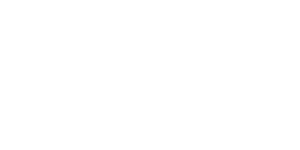

In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

from lvmdap.dap_tools import list_columns,read_DAP_file,map_plot_DAP
from matplotlib import use as mpl_use
#mpl_use('Agg')

%matplotlib inline
from matplotlib import rcParams as rc
rc.update({'font.size': 19,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 19,\
           'ytick.labelsize' : 19,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


from my_utils import search_col

In [31]:
#
# Plottig the results
#
import matplotlib.colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mpl_colors

class scatter():
    def __init__(self,x,y,ax,size=1,**kwargs):
        self.n = len(x)
        self.ax = ax
        self.ax.figure.canvas.draw()
        self.size_data=size
        self.size = size
        self.sc = ax.scatter(x,y,s=self.size,**kwargs)
        self._resize()
        self.cid = ax.figure.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self,event=None):
        ppd=72./self.ax.figure.dpi
        trans = self.ax.transData.transform
        s =  ((trans((1,self.size_data))-trans((0,0)))*ppd)[1]
        if s != self.size:
            self.sc.set_sizes(s**2*np.ones(self.n))
            self.size = s
            self._redraw_later()

    def _redraw_later(self):
        self.timer = self.ax.figure.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.ax.figure.canvas.draw_idle())
        self.timer.start()
        


def gamma_scale(flux,gamma):
    return (flux/np.abs(flux))*(np.abs(flux))**gamma

def gamma_scale_abs(flux,gamma):
    return (np.abs(flux))**gamma

def map_plot_DAP_ax(ax = None, tab_DAP = None ,line='flux_Halpha_6562.85', \
                 vmin=0, vmax=0, title=None, filename='junk',\
                 cmap='Spectral', fsize=5, figs_dir='.',fig_type=None,\
                 gamma=1.0, sf=1.0, tab_pt=None):

    rc.update({'font.size': 12,\
               'font.weight': 900,\
               'text.usetex': True,\
               'path.simplify'           :   True,\
               'xtick.labelsize' : 12,\
               'ytick.labelsize' : 12,\
               'axes.linewidth'  : 2.0,\
               'xtick.major.size'        :   6,\
               'ytick.major.size'        :   6,\
               'xtick.minor.size'        :   3,\
               'ytick.minor.size'        :   3,\
               'xtick.major.width'       :   1,\
               'ytick.major.width'       :   1,\
               'lines.markeredgewidth'   :   1,\
               'legend.numpoints'        :   1,\
               'xtick.minor.width'       :   1,\
               'ytick.minor.width'       :   1,\
               'legend.frameon'          :   False,\
               'legend.handletextpad'    :   0.3,\
               'font.family'    :   'serif',\
               'mathtext.fontset'        :   'stix',\
               'axes.facecolor' : "w",\
               })
    
    X=tab_DAP['ra']
    Y=tab_DAP['dec']
    C=tab_DAP[line]    
    if (title== None):
        title=line.replace("_"," ")
        title=line.replace("_"," ")
    if (vmin==vmax):
        vmin=np.nanmin(C)
        vmax=np.nanmax(C)
    print(line,vmin,vmax)
    if (ax == None):
        fig,ax = plt.subplots(1,1,figsize=(fsize,fsize))
    norm=mpl_colors.PowerNorm(vmin=vmin,vmax=vmax,gamma=gamma)
    scat=scatter(X, Y, ax, size=sf*35.6/3600, c=C, cmap=cmap, norm=norm)
    ax.set_xlabel('Ra [deg]')#,fontsize=21)
    ax.set_ylabel('Dec [deg]')#,fontsize=21)
    xx = ax.get_xlim()
    ax.set_xlim(xx[1],xx[0])
    if (fig_type != None):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(scat.sc, cax=cax,label=fr'{title}')
    if (tab_pt != None):
        for tap_pt_now in tab_pt:
            ax.text(tab_pt['ra'],tab_pt['dec'],tab_pt['id'])

    if (fig_type != None):
        fig.tight_layout()
        fig.savefig(f'{figs_dir}/{filename}.{fig_type}')
        plt.close()




In [32]:
#
# Reading the DAP file
#

tab_DAP = read_DAP_file(out_file_dap)

In [33]:
#
# Orion dataset
#

#tab_DAP_cm=read_DAP_file('output_dap/junk_orion_CM.dap.fits.gz',verbose=True)
#tab_DAP_nb=read_DAP_file('output_dap/junk_orion_nb.dap.fits.gz',verbose=True)


In [34]:
#tab_DAP_cm=read_DAP_file('output_dap_v1.1.0_tests/dap-cm-00006109.dap.fits.gz',verbose=True)
#tab_DAP_nb=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-00006109.dap.fits.gz',verbose=True)

#tab_DAP_nb_test=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-00006109.dap.fits.gz',verbose=True)
#tab_DAP_nb_test=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-OK-00006109.dap.fits.gz',verbose=True)
#tab_DAP_nb_test=read_DAP_file('output_dap_v1.1.0_tests/dap-nb-00006109_few.dap.fits.gz',verbose=True)

#tab_DAP_cm_test=read_DAP_file('output_dap_v1.1.0_tests/test-10.dap.fits.gz',verbose=True)
#output_dap_v1.1.0_tests/test-10.dap.fits.gz

flux_Halpha_6562.85 -100 100000
disp_Halpha_6562.85 0.2 0.75
vel_Halpha_6562.85 -5 5
flux_pe_6562.85 -100 100000
disp_pe_6562.85 0.2 0.75
vel_pe_6562.85 -5 5
flux_pek_6562.85 -100 100000
disp_pek_6562.85 0.2 0.75
vel_pek_6562.85 -5 5


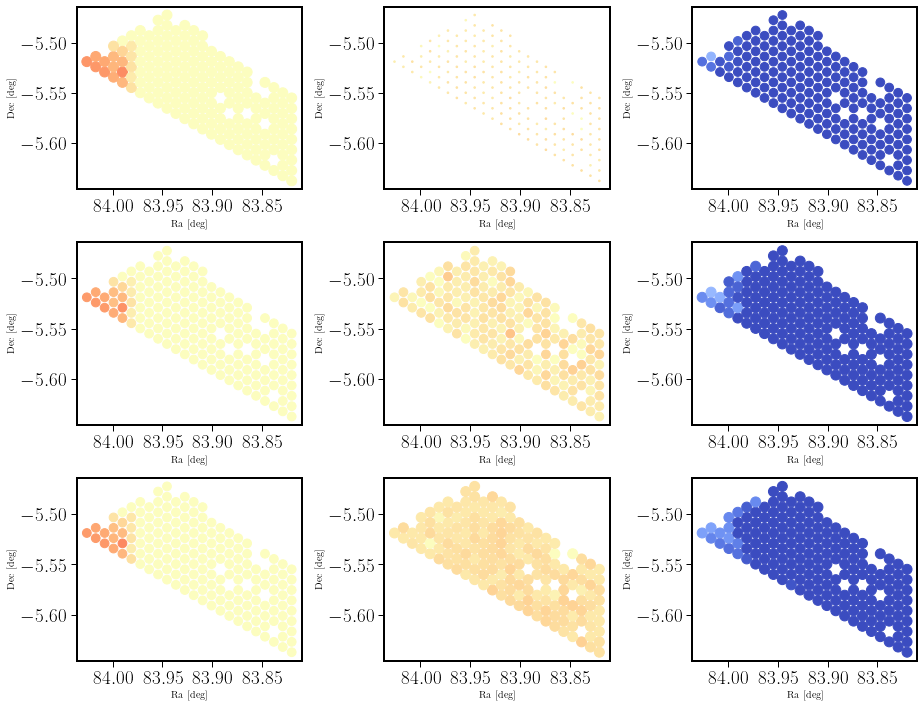

In [35]:
#tab_DAP['junk']=1.5*tab_DAP['flux_Halpha_6562.85']
%matplotlib inline
#tab_DAP = tab_DAP_nb_test
#tab_DAP = tab_DAP_cm_test

fig,axes = plt.subplots(3,3, figsize=(13,10))
#fig,axes = plt.subplots(2,3, figsize=(7,4))

#axes[0][0].text(97.8,5.15,'NP v1.0.0')
#axes[1][0].text(97.8,5.15,'PM v1.0.0')

fsize = 20
map_plot_DAP_ax(ax=axes[0][0],tab_DAP=tab_DAP,line='flux_Halpha_6562.85', \
                 vmin=-100, vmax=100000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10    
map_plot_DAP_ax(ax=axes[0][1],tab_DAP=tab_DAP,line='disp_Halpha_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[0][2],tab_DAP = tab_DAP,line='vel_Halpha_6562.85', \
              vmin=-5, vmax=5, title=None, filename='junk',\
             cmap='coolwarm', fsize=fsize, figs_dir='figs',gamma=1,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[1][0],tab_DAP=tab_DAP,line='flux_pe_6562.85', \
                 vmin=-100, vmax=100000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[1][1],tab_DAP=tab_DAP,line='disp_pe_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)
fsize = 10
map_plot_DAP_ax(ax=axes[1][2],tab_DAP = tab_DAP,line='vel_pe_6562.85', \
                 vmin=-5, vmax=5, title=None, filename='junk',\
             cmap='coolwarm', fsize=fsize, figs_dir='figs',gamma=1,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[2][0],tab_DAP=tab_DAP,line='flux_pek_6562.85', \
                 vmin=-100, vmax=100000, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)

fsize = 10
map_plot_DAP_ax(ax=axes[2][1],tab_DAP=tab_DAP,line='disp_pek_6562.85', \
                 vmin=0.2, vmax=0.75, title=None, filename='junk',\
             cmap='magma', fsize=fsize, figs_dir='figs',gamma=0.5,fig_type=None)
fsize = 10
map_plot_DAP_ax(ax=axes[2][2],tab_DAP = tab_DAP,line='vel_pek_6562.85', \
                 vmin=-5, vmax=5, title=None, filename='junk',\
             cmap='coolwarm', fsize=fsize, figs_dir='figs',gamma=1,fig_type=None)



plt.tight_layout()


0.9915831294008894 0.9870520334237879 1.0131178156143394 vel: 1.0440224635009818


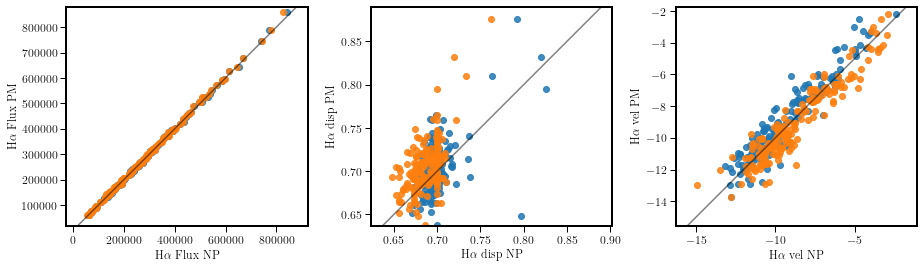

In [36]:
fig,axes = plt.subplots(1,3,figsize=(13,4.5))

#tab_DAP = tab_DAP_nb_test

mask_flux = tab_DAP['flux_Halpha_6562.85']>10000
rat_flux = np.median((tab_DAP['flux_Halpha_6562.85']/tab_DAP['flux_pe_6562.85'])[mask_flux])
rat_disp = np.median((tab_DAP['disp_Halpha_6562.85']/tab_DAP['disp_pe_6562.85'])[mask_flux])
rat_vel = np.median((tab_DAP['vel_Halpha_6562.85']/tab_DAP['vel_pe_6562.85'])[mask_flux])

print(rat_flux,rat_disp,1/rat_disp,'vel:',rat_vel)

ax = axes[0]
ax.scatter(tab_DAP['flux_Halpha_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['flux_pek_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ Flux NP')
ax.set_ylabel(r'H$\alpha$ Flux PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)

ax.set_aspect('equal', 'box')
#ax.text(0,x_lim[1]*0.85,'v1.0.0')

ax = axes[1]
ax.scatter(tab_DAP['disp_Halpha_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['disp_pek_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ disp NP')
ax.set_ylabel(r'H$\alpha$ disp PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

ax = axes[2]
ax.scatter(tab_DAP['vel_Halpha_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['vel_pek_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ vel NP')
ax.set_ylabel(r'H$\alpha$ vel PM')
ax.set_aspect('equal', adjustable='box')

#ax.set_xlim(-5,5)
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

plt.tight_layout()






<IPython.core.display.Javascript object>


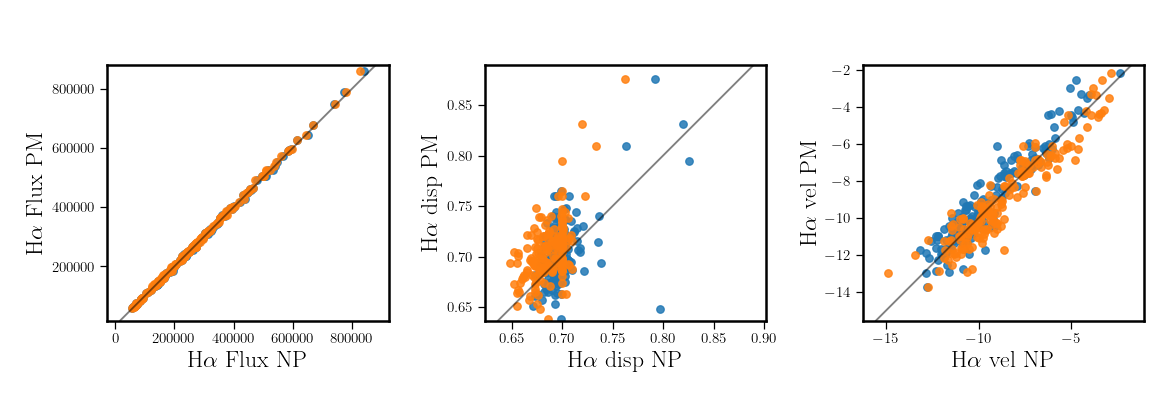

0.9915831294008894 0.9870520334237879 1.0131178156143394 vel: 1.0440224635009818


In [39]:

from scipy.stats import gaussian_kde

def scatter_den(x,y,cmap='viridis', ax=None):
        #Combine x and y into a 2D array
        xy = np.vstack([x, y])

        # Calculate point density
        kde = gaussian_kde(xy)
        density = kde(xy)
        
        # Normalize density for color and size
        norm_density = (density - density.min()) / (density.max() - density.min())
        size = 50 + norm_density * 200  # scale size between 50 and 250
        
        # Plot scatter with color and size based on density
        if (ax==None):
            fig,ax = plt.subplots(figsize=(5,5))
        ax.scatter(x, y, c=norm_density, s=size, cmap=cmap, edgecolors='k', alpha=0.7)




fig,axes = plt.subplots(1,3,figsize=(13,4.5))

#tab_DAP = tab_DAP_nb_test

mask_flux = tab_DAP['flux_Halpha_6562.85']>10000
rat_flux = np.median((tab_DAP['flux_Halpha_6562.85']/tab_DAP['flux_pe_6562.85'])[mask_flux])
rat_disp = np.median((tab_DAP['disp_Halpha_6562.85']/tab_DAP['disp_pe_6562.85'])[mask_flux])
rat_vel = np.median((tab_DAP['vel_Halpha_6562.85']/tab_DAP['vel_pe_6562.85'])[mask_flux])

print(rat_flux,rat_disp,1/rat_disp,'vel:',rat_vel)

ax = axes[0]



ax.scatter(tab_DAP['flux_Halpha_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['flux_pek_6562.85'],tab_DAP['flux_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ Flux NP')
ax.set_ylabel(r'H$\alpha$ Flux PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)

ax.set_aspect('equal', 'box')
#ax.text(0,x_lim[1]*0.85,'v1.0.0')

ax = axes[1]
ax.scatter(tab_DAP['disp_Halpha_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['disp_pek_6562.85'],tab_DAP['disp_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ disp NP')
ax.set_ylabel(r'H$\alpha$ disp PM')
ax.set_aspect('equal', adjustable='box')
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

ax = axes[2]
ax.scatter(tab_DAP['vel_Halpha_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.scatter(tab_DAP['vel_pek_6562.85'],tab_DAP['vel_pe_6562.85'],alpha=0.85)
ax.set_xlabel(r'H$\alpha$ vel NP')
ax.set_ylabel(r'H$\alpha$ vel PM')
ax.set_aspect('equal', adjustable='box')

#ax.set_xlim(-5,5)
x_lim = ax.get_xlim()
ax.set_ylim(x_lim)
ax.plot(x_lim,x_lim,color='black',alpha=0.5)
ax.set_aspect('equal', 'box')

plt.tight_layout()




